# SIDES Simulation

This directory contains models made with simulations generated using [SIDES](https://gitlab.lam.fr/mbethermin/sides-public-release/-/tree/main/PYSIDES).  

The catalog and maps generated in the Notebook [S0_Generate_Simulated_Herschel_Maps_and_Catalog](http://localhost:8888/notebooks/Repositories/simstack3/viero2022/notebooks/Appendix/sides_simulation/S0_Generate_Simulated_Herschel_Maps_and_Catalog.ipynb) is used here to compare to the COSMOS2020 sample in Viero2022.

This notebook investigates the degree of bias by low-z interloper galaxies to the high-z dust temperature estimates.  This is acheived by sampling the P(z) of each object in the COSMOS2020 sample, and then identifying the nearest counterpart at that redshift in the SIDES catalog, storing its flux at each wavelength, and fitting an SED to estimate its temperature. Finally, the stored fluxes are averaged and fit with an SED to estimate the stacked temperature, and the two are compared.  

We find a small bias with increasing uncertainty in the P(z), which is predominantly at high redshifts and low stellar mass.   

In [1]:
# Standard modules
import pdb
import os
import sys
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9

from lmfit import Parameters, minimize, fit_report

import warnings
warnings.filterwarnings("ignore")

sys.path.append("../../../..")

from simstackwrapper import SimstackWrapper
from simstackresults import SimstackResults
from simstackplots import SimstackPlots
from simstacktoolbox import SimstackToolbox

#from scipy.signal import find_peaks
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Import saved stacking results
combined_pickle_filename = "cosmos2020_farmer_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8_10p0_X_4_foregnd_atonce_bootstrap_1-150"
combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", combined_pickle_filename)
underscore_suffix = ""
path_pickle_file = os.path.join(combined_pickle_path, combined_pickle_filename+".pkl")
simstack_object = SimstackToolbox.import_saved_pickles(path_pickle_file)

In [3]:
# Import catalog with SimstackWrapper
path_ini_file = os.path.join(combined_pickle_path, "cosmos2020_farmer.ini")
path_pickle_file = os.path.join(combined_pickle_path, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

# Import Catalog and PZ to link objects and their photometric redshift PDFs

### SIDES Catalog

In [4]:
# Import catalog with SimstackWrapper
combined_pickle_filename = "sides_allz_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8p0_X_4_foregnd_atonce_bootstrap_1-80"
combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", "spire" , combined_pickle_filename)
underscore_suffix = ""
path_ini_file = os.path.join(combined_pickle_path, "sides_simulation.ini")
path_pickle_file = os.path.join(combined_pickle_path, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    sides_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [5]:
sides_catalog_object.catalog_dict['tables']['full_table'].tail()

,Unnamed: 0,redshift,ra,dec,Mstar,qflag,SFR,LIR,SMIPS24,S100,S160,SSPIRE250,SSPIRE350,SSPIRE500,S850,Trf,Ain
171393,5582604,8.414977,0.057124,0.481270,3.293016e+09,False,29.130799,2.913080e+11,3.199594e-08,2.193752e-06,0.000007,0.000016,0.000059,0.000123,0.000174,39.886556,-33.674609
171394,5582625,8.387288,0.137851,0.509640,5.761660e+09,False,14.940993,1.494099e+11,1.459517e-08,1.024372e-06,0.000003,0.000008,0.000038,0.000068,0.000066,39.769699,-33.922599
171395,5583008,8.469563,0.572220,0.352991,4.908892e+09,False,27.949331,2.794933e+11,2.350560e-08,1.588244e-06,0.000006,0.000014,0.000061,0.000112,0.000111,40.119094,-33.705929
171396,5583577,8.648121,0.974505,1.053851,4.165142e+09,False,14.366696,1.436670e+11,1.746845e-08,1.093338e-06,0.000004,0.000009,0.000035,0.000073,0.000098,40.874122,-33.903982
171397,5583702,8.732985,0.035478,1.327398,3.519983e+09,False,15.789969,1.578997e+11,1.082463e-08,6.367038e-07,0.000003,0.000005,0.000021,0.000045,0.000058,40.764975,-34.083879


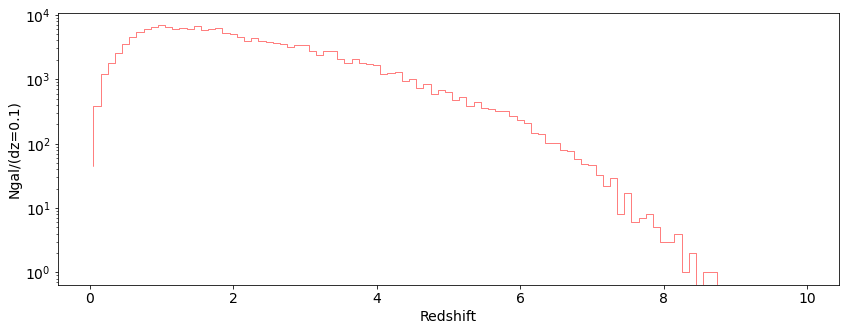

In [6]:
hb = np.linspace(0,10,101)
z_sides = sides_catalog_object.catalog_dict['tables']['full_table']['redshift']
hy, hx = np.histogram(z_sides, bins=hb)

fig = plt.figure(figsize=(14, 5))
plt.step((hx[:-1]+hx[1:])/2, hy/1, c='r',lw=0.5)
                    
plt.yscale('log')
plt.xlabel('Redshift');
plt.ylabel('Ngal/(dz=0.1)');
#plt.xlim([8,10])
#plt.ylim([1e0,1e4])

In [7]:
print('highest redshift={0:0.3f}'.format(np.max(z_sides)))

highest redshift=8.733


### COSMOS2020 Catalog

In [8]:
# Load Table into a pandas DataFrame
cosmos2020 = simstack_catalog_object.catalog_dict['tables']['full_table']

In [9]:
cosmos2020.tail()

,ID,ALPHA_J2000,DELTA_J2000,lp_zBEST,lp_mass_med,ez_restU-V,ez_restV-J,restNUV-R,restR-J,lp_SFR_best,lp_sSFR_med,lp_type,sfg
711880,964439,150.212106,1.787928,0.3207,7.49669,NaN,NaN,1.24270,-0.08177,-1.7330,-8.97360,0,1.0
711881,964440,150.211415,1.788014,0.0490,6.65096,NaN,NaN,6.23957,1.09682,-5.9900,-12.76579,0,0.0
711882,964441,150.212666,1.788418,0.8165,7.61975,NaN,NaN,0.84868,-0.24417,-0.7851,-8.43227,0,1.0
711883,964444,150.212557,1.789332,0.0812,5.16792,NaN,NaN,0.90254,-1.10197,-2.1850,-7.30000,0,1.0
711884,964449,150.201013,1.790721,0.3073,7.28359,NaN,NaN,0.66499,-0.43547,-1.2590,-8.51345,0,1.0


### P(z) 

In [10]:
# Import table with astropy
path_cosmos2020_pz = os.path.join(os.environ['CATSPATH'], "cosmos","PZ","COSMOS2020_FARMER_R1_v2.0_LEPHARE_PZ.fits")
if os.path.isfile(path_cosmos2020_pz):
    print('Open ',path_cosmos2020_pz)
    with fits.open(path_cosmos2020_pz) as hdul_pz:
        hdul_pz.verify('fix')
        cosmos_catalog_pz = hdul_pz[0].data
else:
    print(path_cosmos2020_pz, ' not found')

Open  D:\catalogs\cosmos\PZ\COSMOS2020_FARMER_R1_v2.0_LEPHARE_PZ.fits


In [11]:
# Load Table into a pandas DataFrame
cosmos2020_pz = pd.DataFrame(cosmos_catalog_pz)

In [12]:
cosmos2020_pz.tail()

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,1000,1001
964502,964502.0,0.0,0.000000,0.010244,0.011078,0.011789,0.012833,0.014263,0.018287,0.044225,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
964503,964503.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
964504,964504.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
964505,964505.0,0.0,0.007243,0.008699,0.010084,0.011576,0.012597,0.009745,0.008120,0.014568,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
964506,964506.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001795,0.001811,0.001828,0.001844,0.00186,0.001876,0.001891,0.001906,0.00192,0.001933


### Import SED fitting codes

In [13]:
def black( nu_in, T):
    # h = 6.623e-34     ; Joule*s
    # k = 1.38e-23      ; Joule/K
    # c = 3e8           ; m/s
    # (2*h*nu_in^3/c^2)*(1/( exp(h*nu_in/k*T) - 1 )) * 10^29

    a0 = 1.4718e-21  # 2*h*10^29/c^2
    a1 = 4.7993e-11  # h/k

    num = a0 * nu_in ** 3.0
    den = np.exp(a1 * np.outer(1.0 / T, nu_in)) - 1.0
    ret = num / den

    return ret

In [14]:
def graybody_fn(theta, x, alphain=2.0, betain=1.8):
    A, T = theta

    c_light = 299792458.0  # m/s

    nu_in = np.array([c_light * 1.e6 / wv for wv in x])
    ng = np.size(A)

    base = 2.0 * (6.626) ** (-2.0 - betain - alphain) * (1.38) ** (3. + betain + alphain) / (2.99792458) ** 2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0 ** expo
    w_num = 10 ** A * K * (T * (3.0 + betain + alphain)) ** (3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num / w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T
    graybody = np.reshape(10 ** A, (ng, 1)) * nu_in ** np.reshape(betain, (ng, 1)) * black(nu_in, T) / 1000.0
    powerlaw = np.reshape(w_div, (ng, 1)) * nu_in ** np.reshape(-1.0 * alphain, (ng, 1))
    graybody[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))] = \
        powerlaw[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))]

    return graybody

In [15]:
def fast_sed(m, wavelengths):

    v = m.valuesdict()
    A = np.asarray(v['A'])
    T = np.asarray(v['T_observed'])
    betain = np.asarray(v['beta'])
    alphain = np.asarray(v['alpha'])
    theta_in = A, T

    return graybody_fn(theta_in, wavelengths, alphain=alphain, betain=betain)

In [16]:
def find_sed_min(params, wavelengths, fluxes, covar=None):

    graybody = fast_sed(params, wavelengths)[0]
    delta_y = (fluxes - graybody)

    if (covar is None) or (np.sum(covar) == 0):
        return delta_y
    else:
        if np.shape(covar) == np.shape(fluxes):
            return delta_y ** 2 / covar
        else:
            return np.matmul(delta_y**2, np.linalg.inv(covar))

In [17]:
def fast_sed_fitter(wavelengths, fluxes, covar=None, betain=1.8, alphain=2.0, redshiftin=0, stellarmassin=None):

    t_in = (23.8 + 2.7 * redshiftin + 0.9 * redshiftin ** 2) / (1 + redshiftin)
    if stellarmassin is not None:
        a_in = -47 - redshiftin*0.05 + 11 * (stellarmassin / 10)
    else:
        a_in = -35.0

    fit_params = Parameters()
    fit_params.add('A', value=a_in, vary=True)
    fit_params.add('T_observed', value=t_in, vary=True)
    fit_params.add('beta', value=betain, vary=False)
    fit_params.add('alpha', value=alphain, vary=False)

    fluxin = fluxes
    try:
        sed_params = minimize(find_sed_min, fit_params,
                              args=(wavelengths,),
                              kws={'fluxes': fluxin, 'covar': covar})
        m = sed_params.params
    except:
        m = fit_params

    return m

In [18]:
def estimate_single_sed(wavelengths, fluxes, z=0, m=None):

    sed_params = fast_sed_fitter(wavelengths, fluxes, covar=None, redshiftin=z, stellarmassin=m)
    
    return sed_params

In [23]:
def find_drawn_seds_given_label_id(catalog, sides, id_label, nsims = 1, wv_cat = ["SMIPS24","S100","S160","SSPIRE250","SSPIRE350","SSPIRE500"], wavelengths = [24, 100, 160, 250, 350, 500], plot_fit=False):

    #pdb.set_trace()
    m = [float(i) for i in id_label.split('__')[1].split('_')[2:]]
    z = [float(i) for i in id_label.split('__')[0].split('_')[1:]]

    ind_bin = (catalog['lp_zBEST'] > z[0]) & \
    (catalog['lp_zBEST'] < z[1]) & \
    (catalog['lp_mass_med'] >= m[0]) & \
    (catalog['lp_mass_med'] < m[1]) & \
    (catalog['sfg'] == 1)
    idz=catalog.ID[ind_bin].values

    # Find all sfg in a mass range
    #subsides = sides[(sides['Mstar']>=10**m[0]) & (sides['Mstar']<=10**m[1]) & (sides['qflag']==0)]
    # Find all sfg in a mass and redshift range
    subsides_bin = sides[(sides['redshift']>=z[0]) & (sides['redshift']<z[1]) & (sides['Mstar']>=10**m[0]) & (sides['Mstar']<10**m[1]) & (sides['qflag']==0)]

    flux_bin = np.zeros([nsims, len(idz),len(wv_cat)])
    flux_bin0= np.zeros([len(idz),len(wv_cat)])
    a_cat0 = np.zeros(len(idz))
    a_cat = np.zeros([nsims, len(idz)])
    trf_cat0 = np.zeros(len(idz))
    trf_cat = np.zeros([nsims, len(idz)])
    z_drawn = np.zeros([nsims, len(idz)])
    z_best = catalog['lp_zBEST'].loc[ind_bin]
    m_best = catalog['lp_mass_med'].loc[ind_bin]
    m_drawn = np.zeros([nsims, len(idz)])
    gal_id_bin = np.zeros([nsims, len(idz)])
    wv_mod = np.linspace(8,1000,1000)
    
    for i in range(len(idz)):
        cin = cosmos2020_pz[0] == idz[i]
        indz = cosmos2020_pz[0][cin]

        # BEST-z
        try:
            dz = abs(subsides_bin['redshift'] - z_best.values[i])
            if np.min(dz) < 0.1:
                idx_sides_0 = np.argmin(dz)
                flux_bin0[i] = subsides_bin.iloc[idx_sides_0][wv_cat].values
                single_sed_params = estimate_single_sed(wavelengths, flux_bin0[i]) 
                a_cat0[i] = single_sed_params['A'].value
                trf_cat0[i] = single_sed_params['T_observed'].value * (1+z_best.values[i])
            else:
                print('No SIDES galaxies of {1:0.1f}Mstar at z={0:0.1f}'.format(z_best.values[i],np.mean(m)))
                # Should hack the flux from the model into here....
        except:
            pdb.set_trace()
            pass

        # DRAWN-z
        pz = cosmos2020_pz.loc[int(indz.values)][1:].astype('float64')/np.sum(cosmos2020_pz.loc[int(indz.values)][1:].astype('float64'))
        if not np.sum(np.isnan(pz)):
            for isim in range(nsims):
                np.random.seed(isim)
                try:
                    draw_redshift = np.random.choice(cosmos2020_pz.iloc[0][1:],p=pz)
                    mzscale = (draw_redshift * cu.redshift).to(u.Mpc, cu.redshift_distance(WMAP9, kind="comoving")) / (z_best.values[i] * cu.redshift).to(u.Mpc, cu.redshift_distance(WMAP9, kind="comoving"))  
                    mdraw = mzscale.value * (10**m_best.iloc[i])
                    subsides = sides[(sides['Mstar']>=mdraw*0.8) & (sides['Mstar']<=mdraw*1.2) & (sides['qflag']==0)]
                    dz = abs(subsides['redshift'] - draw_redshift)
                    
                    if np.min(dz) < 0.15:
                        idx_sides_drawn = np.argmin(dz)
                        
                        # Scale stellar mass and fluxes by ratio of distance modulus'
                        m_drawn[isim, i] = mzscale.value * subsides.iloc[idx_sides_drawn]['Mstar']
                        flux_bin[isim, i] = mzscale.value * subsides.iloc[idx_sides_drawn][wv_cat].values
                        
                        single_sed_params = estimate_single_sed(wavelengths, flux_bin[isim, i] ) 
                        a_cat[isim, i] = single_sed_params['A'].value
                        trf_cat[isim, i] = single_sed_params['T_observed'].value * (1+z_best.values[i]) 
                        z_drawn[isim, i] = draw_redshift
                        
                        gal_id_bin[isim, i] = idx_sides_drawn
                        
                        if plot_fit:
                            if not i % plot_fit:
                                theta = a_cat[isim, i], trf_cat[isim, i] / (1+np.mean(z))
                                graybody = graybody_fn(theta, wv_mod)[0]
                                plt.scatter(wavelengths, flux_bin[isim, i])
                                plt.plot(wv_mod, graybody, c='r', lw=0.5)

                                #pdb.set_trace()
                                single_sed_params = estimate_single_sed(wavelengths, flux_bin[isim, i]) 
                                theta2 = single_sed_params['A'], single_sed_params['T_observed']
                                graybody2 = graybody_fn(theta2, wv_mod)[0]
                                plt.plot(wv_mod, graybody2, c='g', lw=0.5)
                                plt.xscale('log')
                                plt.yscale('log')
                        
                    else:
                        print('No galaxies at {0:0.1f}'.format(draw_redshift))
                        print('dz = {0:0.1f}'.format( np.min(dz) ))
                        #pdb.set_trace()
                except:
                    print('whoopsie')
                    pdb.set_trace()
                    pass

    ave_flux0 = np.mean(flux_bin0, axis=0)
    ave_flux = np.mean(flux_bin,axis=1)
    ngals_out = len(idz)
    
    return flux_bin0, flux_bin, ave_flux0, ave_flux, trf_cat0, trf_cat, z_best, z_drawn, m_best, m_drawn, ngals_out

No galaxies at 6.4
dz = 0.6
No galaxies at 6.0
dz = 0.3
No galaxies at 5.8
dz = 0.2
No galaxies at 6.0
dz = 0.2
No galaxies at 5.6
dz = 0.2


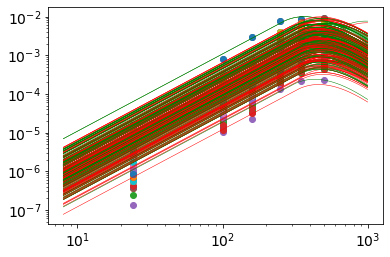

In [24]:
# Check SED fits 
pf = True
flux_bin0, flux_bin, ave_flux0, ave_flux, trf_cat0, trf_cat, z_best, z_drawn, m_best, m_drawn, ngals_out = find_drawn_seds_given_label_id(cosmos2020, sides_catalog_object.catalog_dict['tables']['full_table'],'redshift_5.0_6.0__stellar_mass_10.5_11.0__split_params_1',plot_fit=pf)

In [25]:
def mean_sed_from_pz_loop_ids(self, catalog, sides, nsims=2, wv_cat = ["SMIPS24","S100","S160","SSPIRE250","SSPIRE350","SSPIRE500"], wavelengths = [24, 100, 160, 250, 350, 500]):
    ''' Simulation to estimate effect of interlopers on stacked SED.  
        1. Loop through each bin
        2. Loop through each object in bin and draw redshift from P(z)
        3. Identify SIDES object at that redshift and stellar mass 
        4. Store fluxes and fit SED to find dust temperature
        5. Repeat nsims times, return full_sim_dict
    '''

    bin_keys = list(self.config_dict['parameter_names'].keys())    
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])

    gal_ids = {}
    ave_fluxes_best = {}
    ave_fluxes_drawn = {}
    fluxes_best = {}
    fluxes_drawn = {}
    tdust_best = {}
    tdust_drawn = {}
    redshifts_best = {}
    redshifts_drawn = {}
    masses_best = {}
    masses_drawn = {}
    ave_theta_best = {}
    ave_theta_drawn = {}
    ngals_bin = {}
    full_sim_dict = {'wavelengths': wavelengths, 'bin_dict': self.config_dict['parameter_names'],
                     'ave_sbest': ave_fluxes_best, 'ave_sdrawn': ave_fluxes_drawn, 'sbest': fluxes_best, 'sdrawn': fluxes_drawn, 
                     'tbest': tdust_best, 'tdrawn':tdust_drawn, 
                     'theta_best':ave_theta_best, 'theta_drawn':ave_theta_drawn, 'ids': gal_ids,
                     'mbest': masses_best, 'mdrawn': masses_drawn, 
                     'zbest': redshifts_best, 'zdrawn': redshifts_drawn, 'ngals': ngals_bin}
    
    for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
        for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
            if ip:
                for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                    id_label = "__".join([zlab, mlab, plab])

                    #pdb.set_trace()
                    flux_bin0, flux_bin, ave_flux0, ave_flux, trf_cat0, trf_cat, z_best, z_drawn, m_best, m_drawn, ngals_out = find_drawn_seds_given_label_id(catalog, sides, id_label, nsims)
                    
                    ave_fluxes_best[id_label] = ave_flux0
                    ave_fluxes_drawn[id_label] = ave_flux
                    fluxes_best[id_label] = flux_bin0
                    fluxes_drawn[id_label] = flux_bin
                    tdust_best[id_label] = trf_cat0
                    tdust_drawn[id_label] = trf_cat
                    masses_best[id_label] = m_best
                    masses_drawn[id_label] = m_drawn
                    redshifts_best[id_label] = z_best
                    redshifts_drawn[id_label] = z_drawn
                    ngals_bin[id_label] = ngals_out
                    
                    # Estimate SED Tdust
                    single_sed_params0 = estimate_single_sed(wavelengths, ave_flux0)
                    ave_theta_best[id_label] = [single_sed_params0['A'].value, single_sed_params0['T_observed'].value]
                    
                    ave_theta_drawn[id_label] = np.zeros([nsims, 2])
                    for isim2 in range(nsims):
                        single_sed_params = estimate_single_sed(wavelengths, ave_flux[isim2])
                        ave_theta_drawn[id_label][isim2] = single_sed_params['A'].value, single_sed_params['T_observed'].value

    return full_sim_dict

In [ ]:
# Gerate nsims simulations -- this is really slow because find_drawn_seds_given_label_id fits SEDs to every single z-drawn set of fluxes
nsims = 150
sed_sim_150 = mean_sed_from_pz_loop_ids(simstack_object, cosmos2020, sides_catalog_object.catalog_dict['tables']['full_table'], nsims=nsims)
sed_sim_filename =  '_'.join(['sed_simulation',str(nsims)])+'.pkl'
SimstackToolbox.save_to_pickles(os.path.join(combined_pickle_path,sed_sim_filename), sed_sim_150)
print('Saving', os.path.join(combined_pickle_path,sed_sim_filename))

No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
d

No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.0
d

No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
d

No galaxies at 0.4
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
d

No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
d

No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
d

No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
d

No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.6
dz = nan
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.6
dz = nan
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.6
dz = nan
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.6
dz = nan
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.5
dz = 0.5
No galaxies at 0.6
dz = nan
No galaxies at 0.6
d

No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 0.9
dz = nan
No galaxies at 1.0
dz = nan
No galaxies at 1.0
dz = nan
No galaxies at 1.0
dz = nan
No galaxies at 1.0
dz = nan
No galaxies at 1.0
d

No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.8
d

No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.5
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
d

No galaxies at 0.7
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.8
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.7
dz = nan
No galaxies at 0.6
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.0
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.4
dz = nan
No galaxies at 0.2
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.5
dz = nan
No galaxies at 0.1
dz = nan
No galaxies at 0.3
dz = nan
No galaxies at 0.3
d

In [22]:
def plot_mean_sed_from_pz_full_simulation(self, sim_dict):
    
    bin_keys = list(sim_dict['bin_dict'].keys())
    wavelengths = sim_dict['wavelengths']
    #bin_keys = list(self.config_dict['parameter_names'].keys())    
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(mlen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(41, 11))
    
    ave_fluxes_best = sim_dict['ave_sbest']
    ave_fluxes_drawn = sim_dict['ave_sdrawn']
    fluxes_best = sim_dict['sbest']
    fluxes_drawn = sim_dict['sdrawn']
    tdust_best = sim_dict['tbest']
    tdust_drawn = sim_dict['tdrawn']
    redshifts_best = sim_dict['zbest']
    redshifts_drawn = sim_dict['zdrawn']
    ave_theta_best = sim_dict['theta_best']
    ave_theta_drawn = sim_dict['theta_drawn']
    ngals_bin = sim_dict['ngals']
        
    wv_mod = np.linspace(8,1000,1000)
    
    errors_out = np.zeros([zlen, mlen])
    for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
        for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
            if ip:
                for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                    id_label = "__".join([zlab, mlab, plab])
                    ngals = ngals_bin[id_label]

                    m = [float(i) for i in mlab.split('_')[2:]]
                    z = [float(i) for i in zlab.split('_')[1:]]
                    
                    ax = plt.subplot(gs[3-im, iz])
                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    ax.set_ylim([1e-5,1e-1])
                    ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))

                    nsims = len(fluxes_drawn[id_label])
                    tdust_drawn_sim = np.zeros(nsims)
                    for isim in range(nsims)[::-1]:
                        ave_flux = fluxes_drawn[id_label][isim]                        
                        ax.scatter(wavelengths, ave_flux, c='r')
                        
                        theta_in = ave_theta_drawn[id_label][isim]
                        tdust_drawn_sim[isim] = theta_in[1] * (1+np.mean(z))
                        
                        graybody = graybody_fn(theta_in, wv_mod)[0]
                        
                        if not isim:
                            label='drawn:{0:0.1f}+-{1:0.1f}K'.format(np.mean(tdust_drawn_sim),np.std(tdust_drawn_sim))
                            ax.plot(wv_mod, graybody, label=label, c='r', lw=0.5)
                            errors_out[iz,im]=np.std(tdust_drawn_sim)
                        else:
                            ax.plot(wv_mod, graybody, c='r', lw=0.5)
                            
                                        
                    ave_flux0 = fluxes_best[id_label]
                    ax.scatter(wavelengths, ave_flux0, c='b')

                    theta_in = ave_theta_best[id_label]
                    graybody = graybody_fn(theta_in, wv_mod)[0]
                    label='best={0:0.1f}K'.format(theta_in[1] * (1+np.mean(z)))
                    ax.plot(wv_mod, graybody, label=label, c='b')
                    ax.legend()
                    #pdb.set_trace()

                    if im:
                        ax.set_xticklabels([])
                    else:
                        ax.set_xlabel('wavelength')

                    if iz:
                        ax.set_yticklabels([])
                    else:
                        ax.set_ylabel('Flux')

                    if iz == zlen - 1:
                        ax.yaxis.set_label_position("right")
                        ax.set_ylabel(mlab.replace('stellar_mass_', 'log(M)=').replace('_', '-'))
                        
    return errors_out

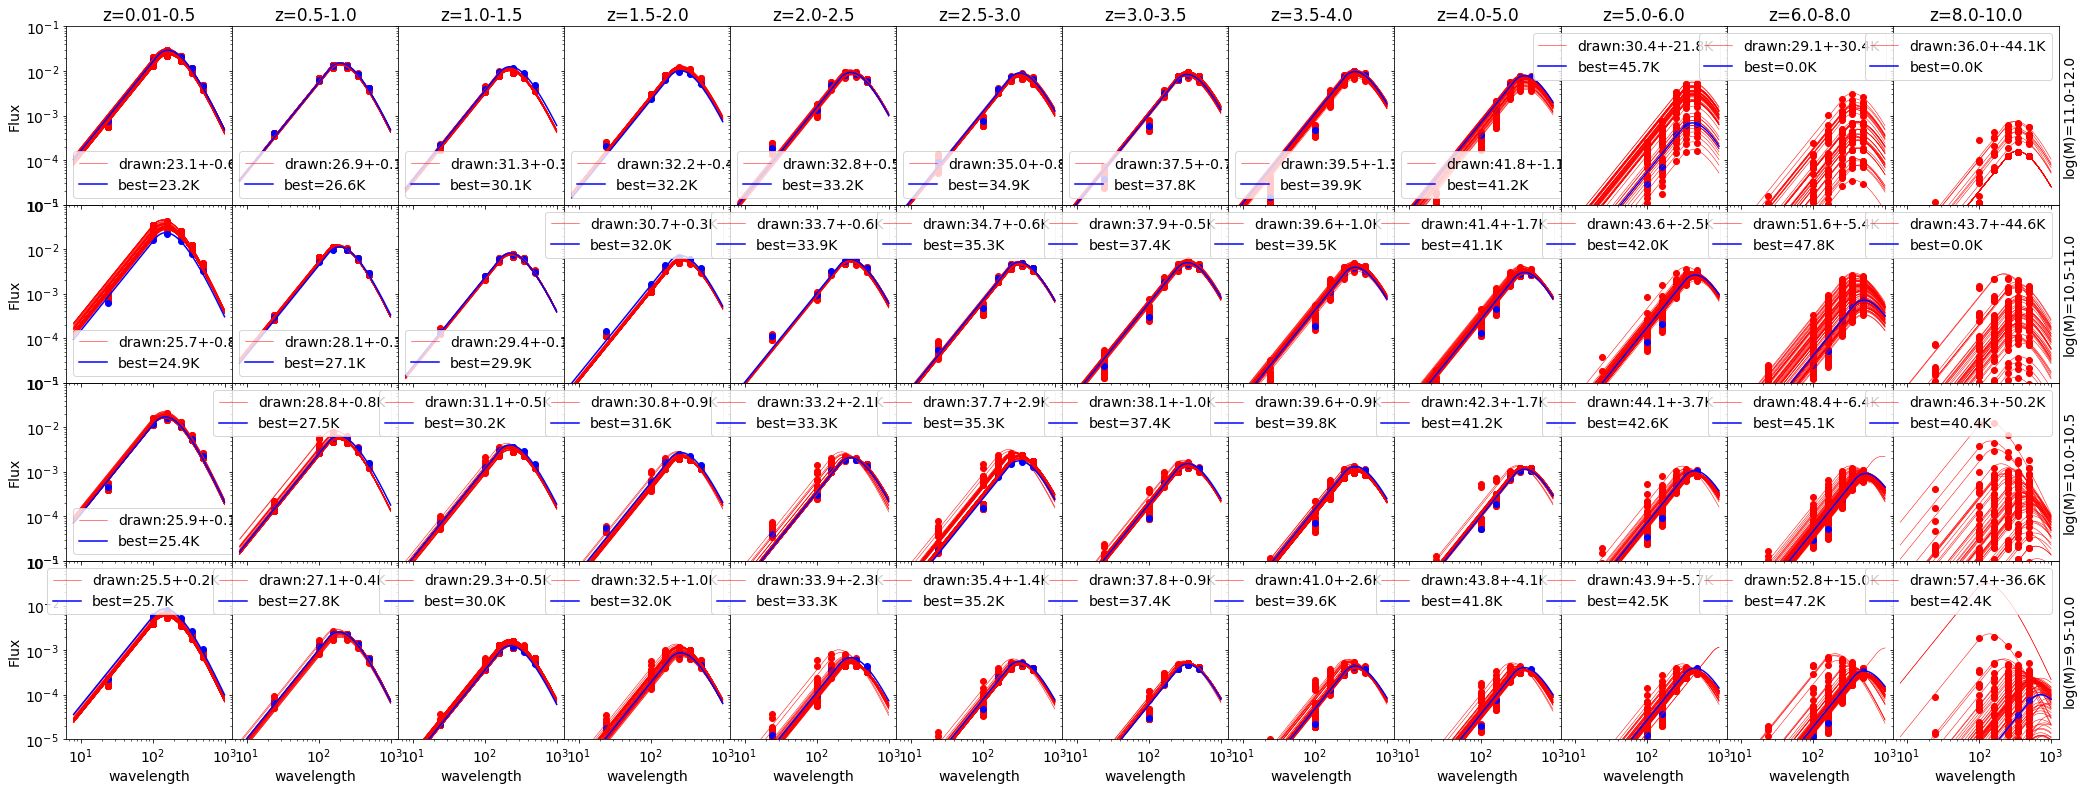

In [43]:
# SED fits to averaged fluxes in bins, where redshifts are drawn from P(z)
# Blue are nominal redshifts (i.e., lp_zBEST used in paper), and Red are sims drawn from P(z)
tdust_errors = plot_mean_sed_from_pz_full_simulation(simstack_object, sed_sim_150)

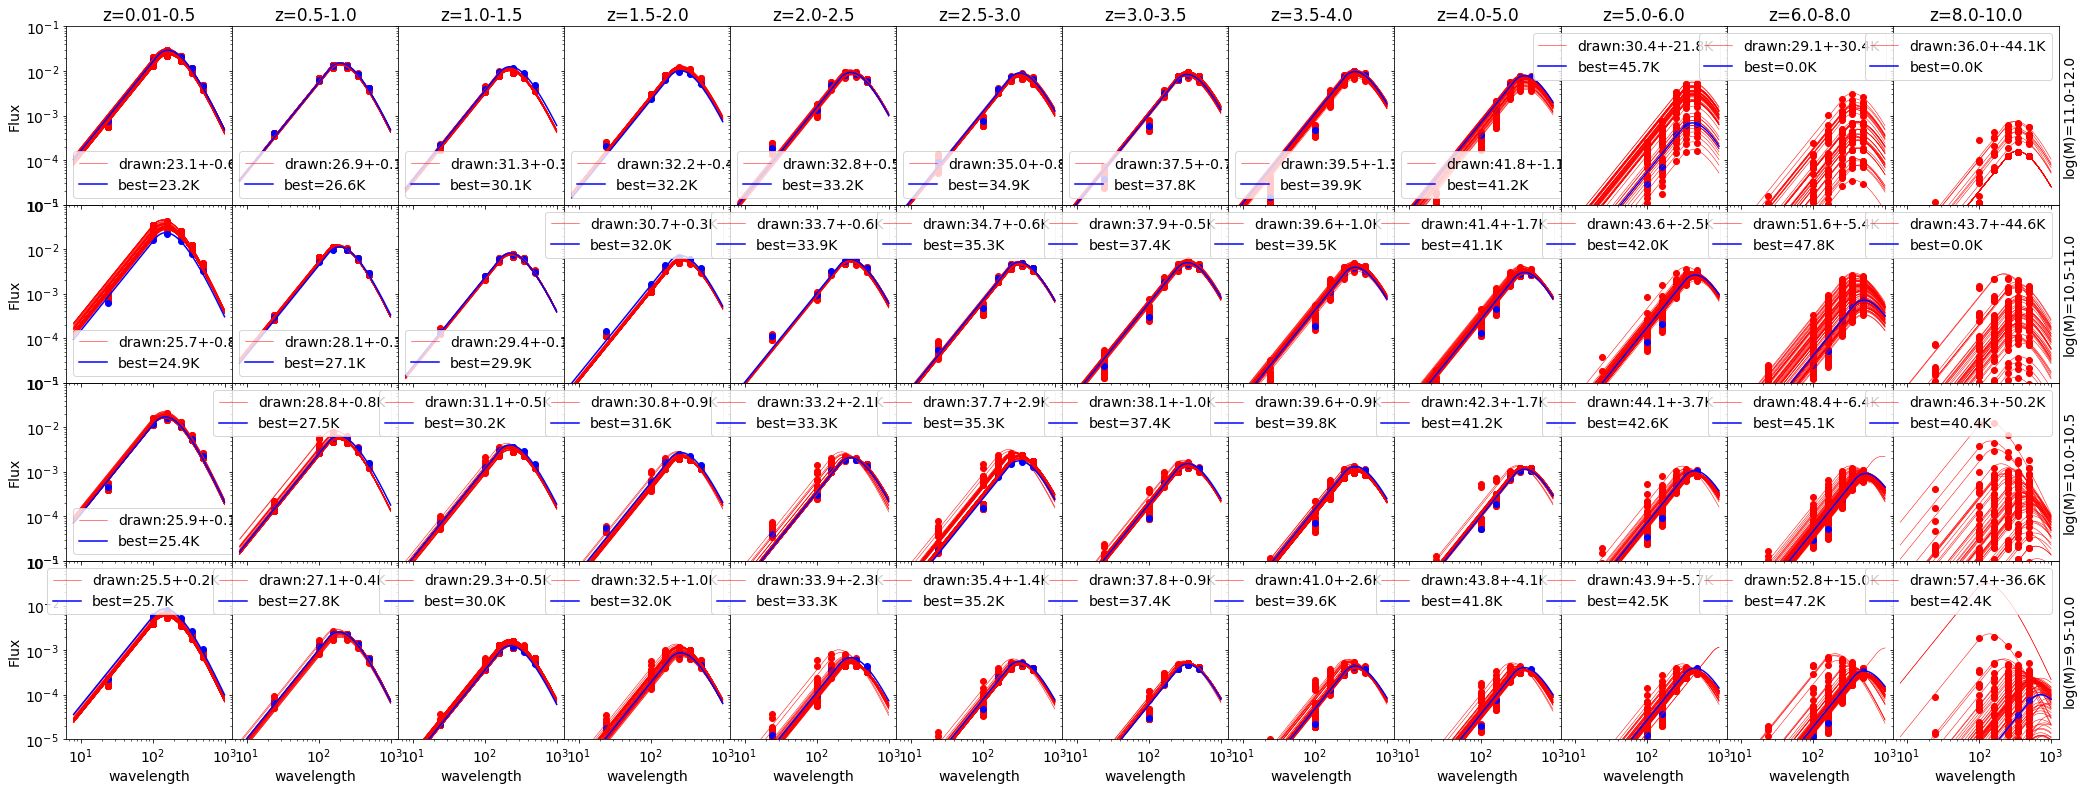

In [24]:
# SED fits to averaged fluxes in bins, where redshifts are drawn from P(z)
# Blue are nominal redshifts (i.e., lp_zBEST used in paper), and Red are sims drawn from P(z)
tdust_errors = plot_mean_sed_from_pz_full_simulation(simstack_object, imported_sed_sim)

In [28]:
print(tdust_errors)

[[ 0.20759376  0.14407229  0.79726284  0.6354599 ]
 [ 0.41632549  0.81696938  0.34402846  0.10199883]
 [ 0.52420775  0.46935138  0.1054209   0.33664426]
 [ 1.03289613  0.91791907  0.34368905  0.43373262]
 [ 2.27491165  2.13680904  0.63235552  0.54912752]
 [ 1.39960656  2.94918591  0.61009363  0.81957885]
 [ 0.87240378  0.96914301  0.54712107  0.66540207]
 [ 2.55085283  0.94947213  0.98548522  1.31912345]
 [ 4.10186711  1.7004354   1.7386957   1.08957375]
 [ 5.7473787   3.73801282  2.5011249  21.79036109]
 [15.04547639  6.38760385  5.43692973 30.43356141]
 [36.55356957 50.19829915 44.56055965 44.14581899]]


In [25]:
def plot_redshift_hist_from_pz_full_simulation(self, sim_dict): 
    
    color = ['b','y','g','r','m']
    bin_keys = list(sim_dict['bin_dict'].keys())
    wavelengths = sim_dict['wavelengths']
    #bin_keys = list(self.config_dict['parameter_names'].keys())    
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(mlen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(40, 12))
    
    fluxes_best = sim_dict['sbest']
    fluxes_drawn = sim_dict['sdrawn']
    #tdust_best = sim_dict['tbest']
    #tdust_drawn = sim_dict['tdrawn']
    redshifts_best = sim_dict['zbest']
    redshifts_drawn = sim_dict['zdrawn']
    ave_theta_best = sim_dict['theta_best']
    ave_theta_drawn = sim_dict['theta_drawn']
    ngals_bin = sim_dict['ngals']
        
    
    wv_mod = np.linspace(8,1000,1000)
    for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
        for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
            if ip:
                for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                    id_label = "__".join([zlab, mlab, plab])
                    ngals = ngals_bin[id_label]

                    m = [float(i) for i in mlab.split('_')[2:]]
                    z = [float(i) for i in zlab.split('_')[1:]]
                    
                    ax = plt.subplot(gs[3-im, iz])
                    ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))

                    nsims = len(fluxes_drawn[id_label])

                    hb = np.linspace(0,10,51)
                        
                    for isim in range(nsims)[::-1]:
                        #pdb.set_trace()
                        z_drawn = redshifts_drawn[id_label][isim]     
                        hy, hx = np.histogram(z_drawn, bins=hb)
                        
                        if not isim and not iz:
                            label='drawn'
                            ax.step((hx[:-1]+hx[1:])/2, hy/1, c='r',lw=0.5, label=label)
                        else:
                            ax.step((hx[:-1]+hx[1:])/2, hy/1, c='r',lw=0.5)
                    
                    z_best = redshifts_best[id_label]
                    hy, hx = np.histogram(z_best, bins=hb)
                    label='best'
                    if not iz: 
                        ax.step((hx[:-1]+hx[1:])/2, hy, c='b',lw=1.5, label=label)
                    else:
                        ax.step((hx[:-1]+hx[1:])/2, hy, c='b',lw=1.5)

                    if not iz: 
                        ax.legend()

                    if im:
                        ax.set_xticklabels([])
                    else:
                        ax.set_xlabel('redshift')

                    if iz:
                        ax.set_yticklabels([])

                    if iz == zlen - 1:
                        ax.yaxis.set_label_position("right")
                        ax.set_ylabel(mlab.replace('stellar_mass_', 'log(M)=').replace('_', '-'))

In [91]:
def plot_flux_contribution_hist_from_pz_full_simulation(self, sim_dict): 
    
    color = ['b','y','g','r','m']
    bin_keys = list(sim_dict['bin_dict'].keys())
    wavelengths = sim_dict['wavelengths']
    #bin_keys = list(self.config_dict['parameter_names'].keys())    
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(mlen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(40, 12))
    
    ave_fluxes_best = sim_dict['ave_sbest']
    ave_fluxes_drawn = sim_dict['ave_sdrawn']
    fluxes_best = sim_dict['sbest']
    fluxes_drawn = sim_dict['sdrawn']
    #tdust_best = sim_dict['tbest']
    #tdust_drawn = sim_dict['tdrawn']
    redshifts_best = sim_dict['zbest']
    redshifts_drawn = sim_dict['zdrawn']
    ave_theta_best = sim_dict['theta_best']
    ave_theta_drawn = sim_dict['theta_drawn']
    ngals_bin = sim_dict['ngals']
        
    
    wv_mod = np.linspace(8,1000,1000)
    hb = np.linspace(0,10,51)
    
    for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
        for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
            if ip:
                for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                    id_label = "__".join([zlab, mlab, plab])
                    #print(id_label)
                    ngals = ngals_bin[id_label]

                    m = [float(i) for i in mlab.split('_')[2:]]
                    z = [float(i) for i in zlab.split('_')[1:]]
                    
                    ax = plt.subplot(gs[3-im, iz])
                    ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))

                    nsims = len(fluxes_drawn[id_label])
                    y_drawn_24 = np.zeros_like(hb)
                    y_drawn_160 = np.zeros_like(hb)
                    y_drawn_500 = np.zeros_like(hb)
                    for isim in range(nsims)[::-1]:
                        
                        z_drawn = redshifts_drawn[id_label][isim]
                        s_drawn = fluxes_drawn[id_label][isim]
                        id_zdrawn = pd.cut(z_drawn, bins=hb, labels=False, include_lowest=True)
                        #pdb.set_trace()
                        zscale = (z_drawn/redshifts_best[id_label])**2
                        for ix, iy in enumerate(np.unique(id_zdrawn)):
                            if np.sum(id_zdrawn) > 0:                                
                                #y_drawn_24[iy] += np.sum([i[0] for i in s_drawn[id_zdrawn==iy]])
                                #y_drawn_500[iy] += np.sum([i[-1] for i in s_drawn[id_zdrawn==iy]])                                
                                y_drawn_24[iy] += np.sum(zscale[id_zdrawn==iy]*[i[0] for i in s_drawn[id_zdrawn==iy]])
                                y_drawn_160[iy] += np.sum(zscale[id_zdrawn==iy]*[i[2] for i in s_drawn[id_zdrawn==iy]])
                                y_drawn_500[iy] += np.sum(zscale[id_zdrawn==iy]*[i[-1] for i in s_drawn[id_zdrawn==iy]])
                    plt.step(hb, y_drawn_24/np.sum(y_drawn_24),'b')
                    plt.step(hb, y_drawn_160/np.sum(y_drawn_160),'g')
                    plt.step(hb, y_drawn_500/np.sum(y_drawn_500),'r')

                    #if id_label == 'redshift_2.0_2.5__stellar_mass_9.5_10.0__split_params_1':
                    #    pdb.set_trace()
                    plt.grid(which='minor')
                    #pdb.set_trace()
                        
                    #if not iz: 
                    #    ax.legend()

                    if im:
                        ax.set_xticklabels([])
                    else:
                        ax.set_xlabel('redshift')

                    if iz:
                        ax.set_yticklabels([])

                    if iz == zlen - 1:
                        ax.yaxis.set_label_position("right")
                        ax.set_ylabel(mlab.replace('stellar_mass_', 'log(M)=').replace('_', '-'))

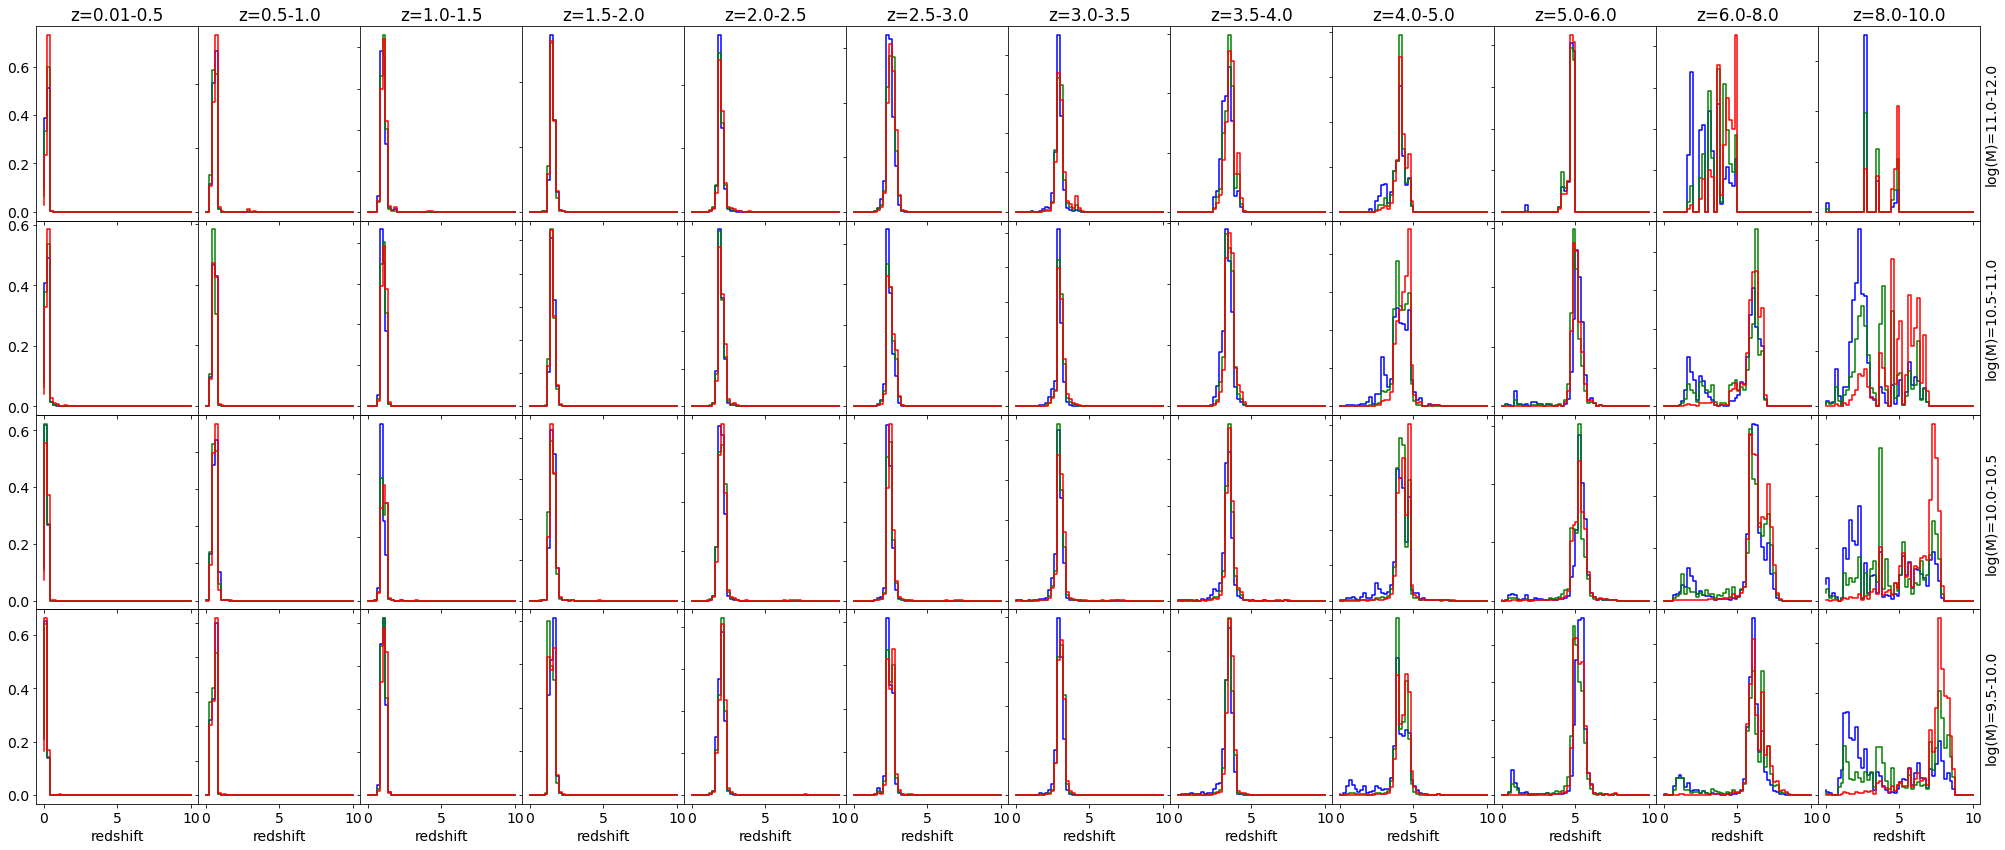

In [92]:
plot_flux_contribution_hist_from_pz_full_simulation(simstack_object, sed_sim_10)

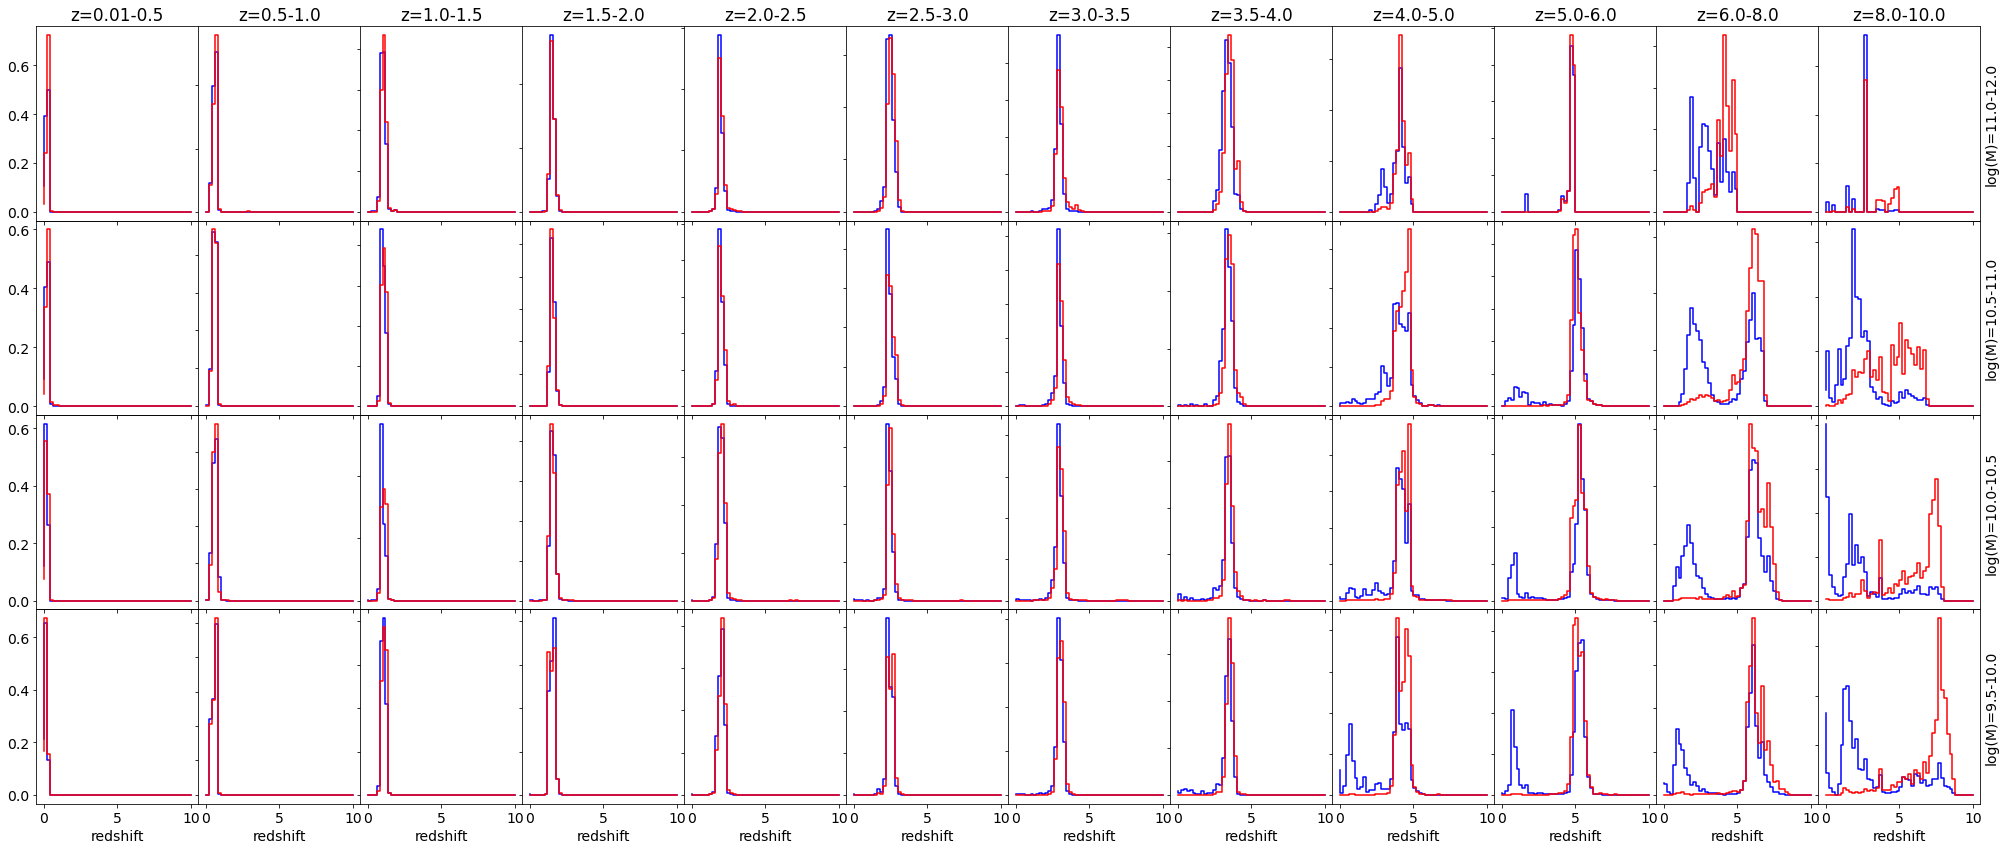

In [71]:
plot_flux_contribution_hist_from_pz_full_simulation(simstack_object, sed_sim_50)

In [26]:
def plot_tdust_hist_from_pz_full_simulation(self, sim_dict): 
    
    color = ['b','y','g','r','m']
    bin_keys = list(sim_dict['bin_dict'].keys())
    wavelengths = sim_dict['wavelengths']
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(mlen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(40, 12))
    
    fluxes_best = sim_dict['sbest']
    fluxes_drawn = sim_dict['sdrawn']
    tdust_best = sim_dict['tbest']
    tdust_drawn = sim_dict['tdrawn']
    redshifts_best = sim_dict['zbest']
    redshifts_drawn = sim_dict['zdrawn']
    ave_theta_best = sim_dict['theta_best']
    ave_theta_drawn = sim_dict['theta_drawn']
    ngals_bin = sim_dict['ngals']
        
    for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
        for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
            if ip:
                for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                    id_label = "__".join([zlab, mlab, plab])
                    ngals = ngals_bin[id_label]

                    m = [float(i) for i in mlab.split('_')[2:]]
                    z = [float(i) for i in zlab.split('_')[1:]]
                    
                    ax = plt.subplot(gs[3-im, iz])
                    ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))

                    nsims = len(fluxes_drawn[id_label])

                    hb = np.linspace(10,60,26)
                    for isim in range(nsims)[::-1]:
                        #pdb.set_trace()
                        t_drawn = tdust_drawn[id_label][isim]     
                        #t_drawn = ave_theta_drawn[id_label][isim][1]
                        hy, hx = np.histogram(t_drawn, bins=hb)
                        
                        if not isim and not iz:
                            label='drawn'
                            ax.step((hx[:-1]+hx[1:])/2, hy/1, c='r',lw=0.5, label=label)
                        else:
                            ax.step((hx[:-1]+hx[1:])/2, hy/1, c='r',lw=0.5)
                    
                    t_best = tdust_best[id_label]
                    #t_best = ave_theta_best[id_label][1]
                    hy, hx = np.histogram(t_best, bins=hb)
                    label='best'
                    if not iz: 
                        ax.step((hx[:-1]+hx[1:])/2, hy, c='b',lw=1.5, label=label)
                    else:
                        ax.step((hx[:-1]+hx[1:])/2, hy, c='b',lw=1.5)

                    if not iz: 
                        ax.legend()

                    if im:
                        ax.set_xticklabels([])
                    else:
                        ax.set_xlabel('Tdust')

                    if iz:
                        ax.set_yticklabels([])

                    if iz == zlen - 1:
                        ax.yaxis.set_label_position("right")
                        ax.set_ylabel(mlab.replace('stellar_mass_', 'log(M)=').replace('_', '-'))

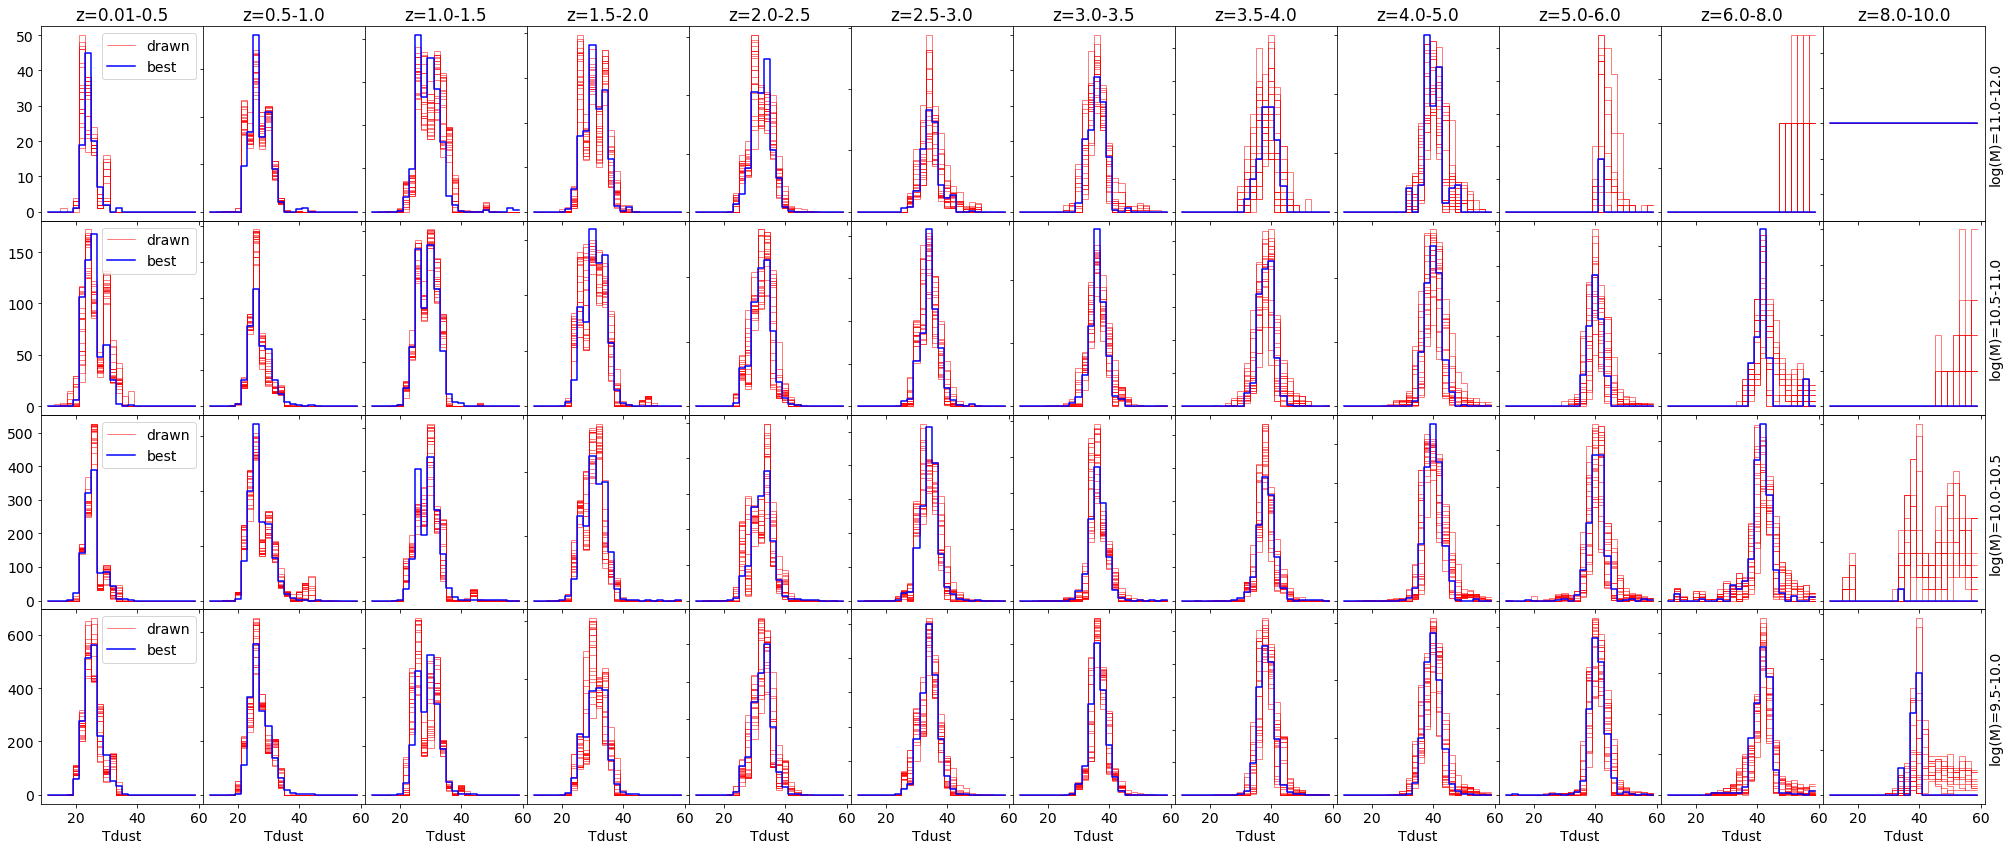

In [27]:
# Histogram of effective rest-frame Tdust of objects in each bin.  Blue are the nominal redshifts, and red are redshifts drawn from each objects P(z). 
# As anticipated there is an excess of hot sources at high redshift as they are confused lower redshift objects; we find that they bias the result, but the effect is subdominant to the increased variance.  
# The absence of signal in high-redshift, high-mass bins, and z>9, reflect the limits of the SIDES simulation.  
plot_tdust_hist_from_pz_full_simulation(simstack_object, sed_sim_25)

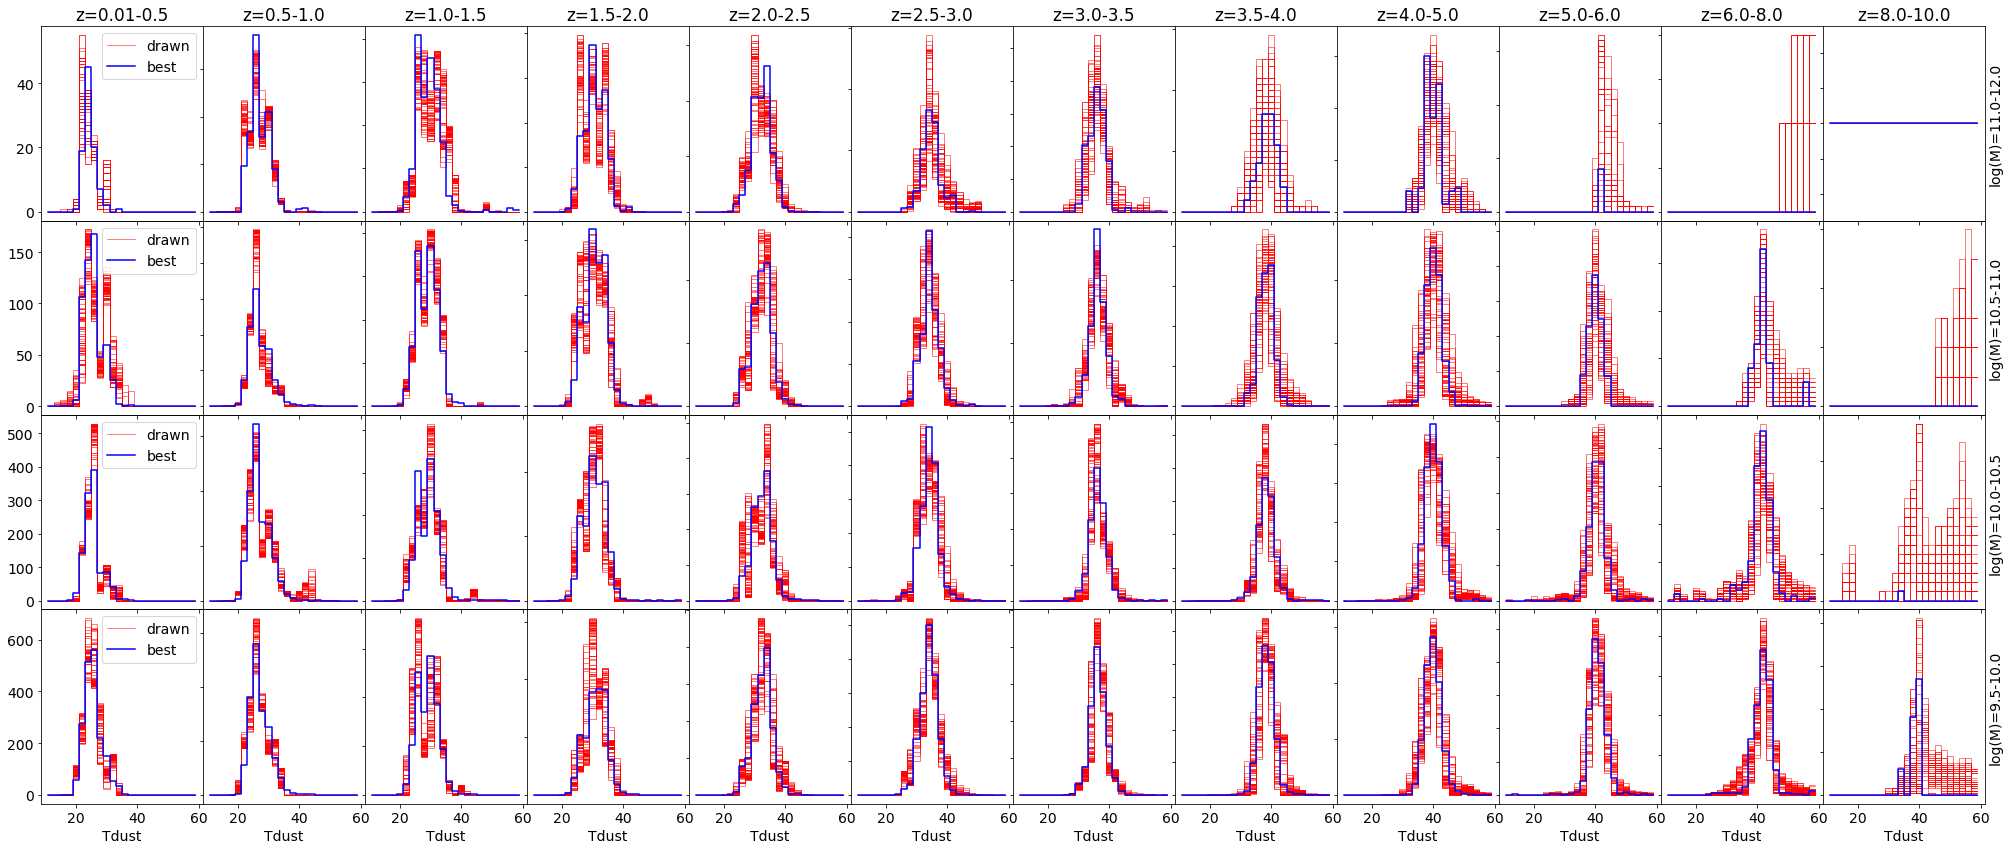

In [28]:
# Histogram of effective rest-frame Tdust of objects in each bin.  Blue are the nominal redshifts, and red are redshifts drawn from each objects P(z). 
# As anticipated there is an excess of hot sources at high redshift as they are confused lower redshift objects; we find that they bias the result, but the effect is subdominant to the increased variance.  
# The absence of signal in high-redshift, high-mass bins, and z>9, reflect the limits of the SIDES simulation.  
plot_tdust_hist_from_pz_full_simulation(simstack_object, sed_sim_100)

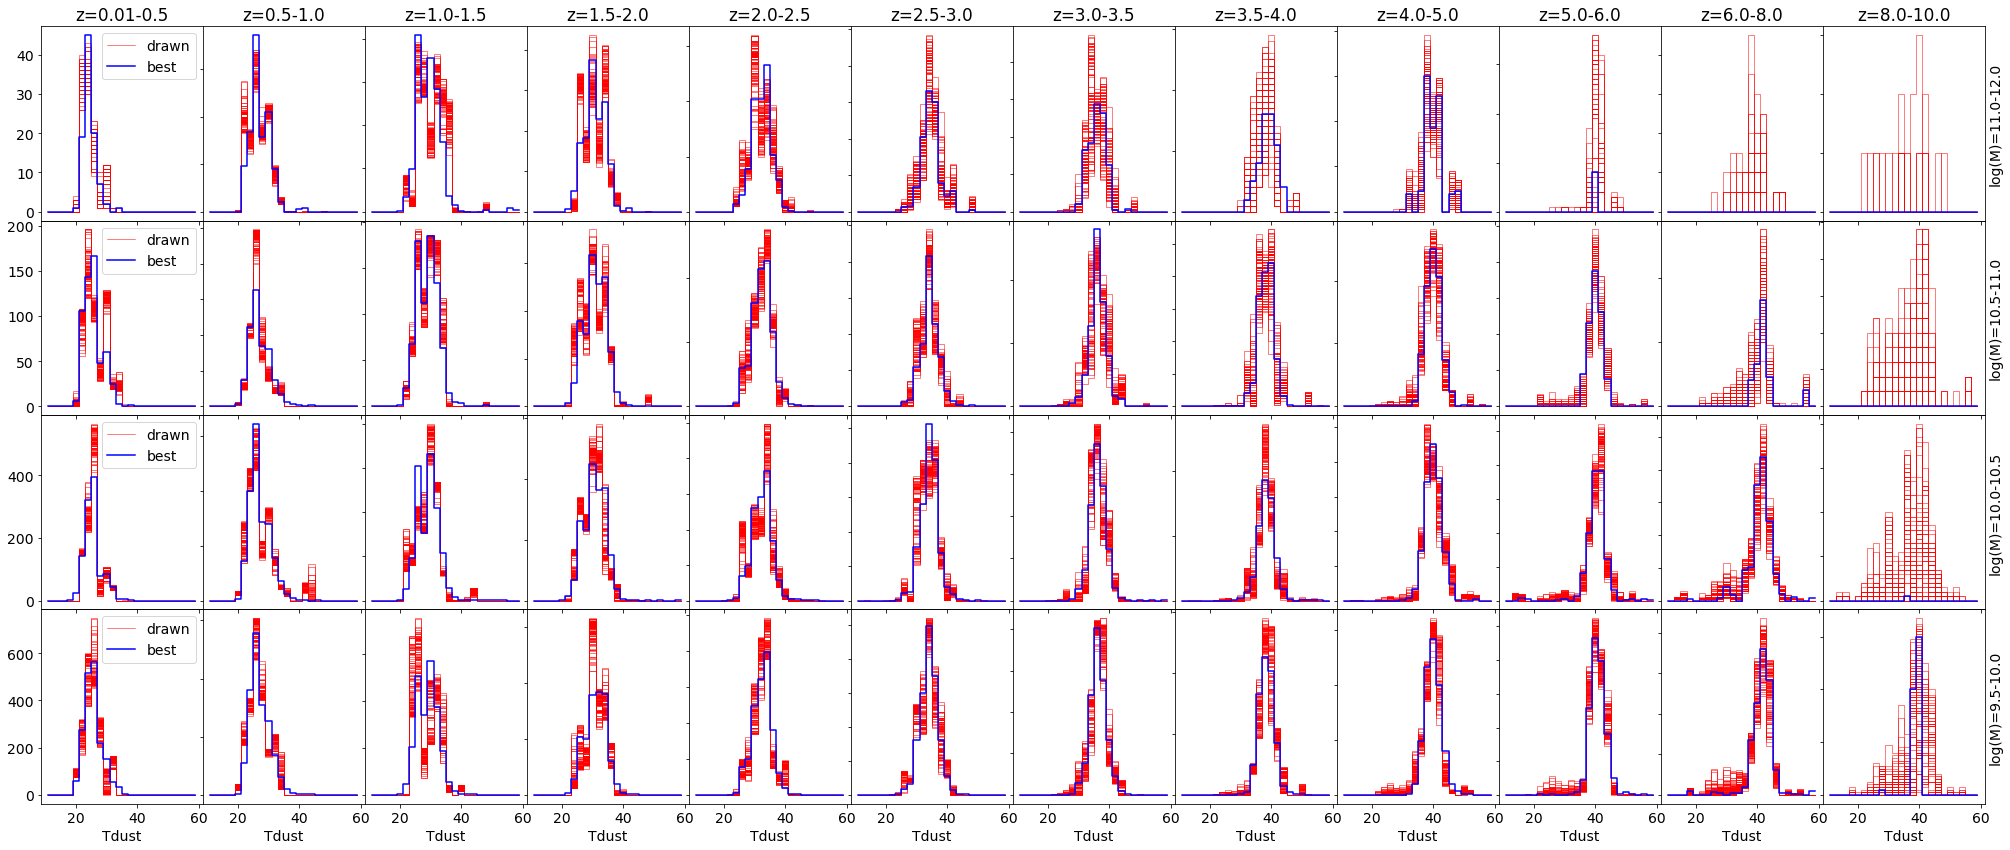

In [104]:
# Histogram of effective rest-frame Tdust of objects in each bin.  Blue are the nominal redshifts, and red are redshifts drawn from each objects P(z). 
# As anticipated there is an excess of hot sources at high redshift as they are confused lower redshift objects; we find that they bias the result, but the effect is subdominant to the increased variance.  
# The absence of signal in high-redshift, high-mass bins, and z>9, reflect the limits of the SIDES simulation.  
plot_tdust_hist_from_pz_full_simulation(simstack_object, imported_sed_sim)

In [45]:
def plot_tdust_hist_from_pz_mean_simulation(self, sim_dict): 
    
    color = ['b','y','g','r','m']
    bin_keys = list(sim_dict['bin_dict'].keys())
    wavelengths = sim_dict['wavelengths']
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(mlen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(40, 12))
    
    fluxes_best = sim_dict['sbest']
    fluxes_drawn = sim_dict['sdrawn']
    tdust_best = sim_dict['tbest']
    tdust_drawn = sim_dict['tdrawn']
    redshifts_best = sim_dict['zbest']
    redshifts_drawn = sim_dict['zdrawn']
    ave_theta_best = sim_dict['theta_best']
    ave_theta_drawn = sim_dict['theta_drawn']
    ngals_bin = sim_dict['ngals']
        
    for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
        for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
            if ip:
                for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                    id_label = "__".join([zlab, mlab, plab])
                    ngals = ngals_bin[id_label]

                    m = [float(i) for i in mlab.split('_')[2:]]
                    z = [float(i) for i in zlab.split('_')[1:]]
                    
                    ax = plt.subplot(gs[3-im, iz])
                    ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))

                    nsims = len(fluxes_drawn[id_label])

                    hb = np.linspace(10,60,26)
                    #pdb.set_trace()
                    tdust_drawn_mean = np.mean(tdust_drawn[id_label],axis=1) 
                    hy, hx = np.histogram(tdust_drawn_mean, bins=hb)
                    ax.step((hx[:-1]+hx[1:])/2, hy/1, c='r',lw=1.5, label='Drawn Mean')
                    ax.vlines(np.mean(tdust_drawn_mean), min(hy), max(hy), color='r', ls='--', lw=2)
                    
                    t_best = tdust_best[id_label]
                    label='Best Mean'
                    ax.vlines(np.mean(t_best), min(hy), max(hy), color='k', ls=':', lw=3) 

                    if not iz: 
                        ax.legend()

                    if im:
                        ax.set_xticklabels([])
                    else:
                        ax.set_xlabel('Tdust')

                    if iz:
                        ax.set_yticklabels([])

                    if iz == zlen - 1:
                        ax.yaxis.set_label_position("right")
                        ax.set_ylabel(mlab.replace('stellar_mass_', 'log(M)=').replace('_', '-'))

In [46]:
def plot_tdust_hist_from_pz_full_simulation2(self, sim_dict): 
    
    color = ['b','y','g','r','m']
    bin_keys = list(sim_dict['bin_dict'].keys())
    wavelengths = sim_dict['wavelengths']
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(mlen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(40, 12))
    
    fluxes_best = sim_dict['sbest']
    fluxes_drawn = sim_dict['sdrawn']
    tdust_best = sim_dict['tbest']
    tdust_drawn = sim_dict['tdrawn']
    redshifts_best = sim_dict['zbest']
    redshifts_drawn = sim_dict['zdrawn']
    ave_theta_best = sim_dict['theta_best']
    ave_theta_drawn = sim_dict['theta_drawn']
    ngals_bin = sim_dict['ngals']
        
    for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
        for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
            if ip:
                for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                    id_label = "__".join([zlab, mlab, plab])
                    ngals = ngals_bin[id_label]

                    m = [float(i) for i in mlab.split('_')[2:]]
                    z = [float(i) for i in zlab.split('_')[1:]]
                    
                    ax = plt.subplot(gs[3-im, iz])
                    ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))

                    nsims = len(fluxes_drawn[id_label])

                    hb = np.linspace(10,60,26)
                    for isim in range(nsims)[::-1]:
                        #pdb.set_trace()
                        t_drawn = tdust_drawn[id_label][isim]     
                        hy, hx = np.histogram(t_drawn, bins=hb)
                        
                        if not isim and not iz:
                            label='drawn'
                            ax.step((hx[:-1]+hx[1:])/2, hy/1, c='r',lw=0.5, label=label)
                        else:
                            ax.step((hx[:-1]+hx[1:])/2, hy/1, c='r',lw=0.5)
                    
                    t_best = tdust_best[id_label]
                    hy, hx = np.histogram(t_best, bins=hb)
                    label='best'
                    if not iz: 
                        ax.step((hx[:-1]+hx[1:])/2, hy, c='b',lw=1.5, label=label)
                    else:
                        ax.step((hx[:-1]+hx[1:])/2, hy, c='b',lw=1.5)

                    if not iz: 
                        ax.legend()

                    if im:
                        ax.set_xticklabels([])
                    else:
                        ax.set_xlabel('Tdust')

                    if iz:
                        ax.set_yticklabels([])

                    if iz == zlen - 1:
                        ax.yaxis.set_label_position("right")
                        ax.set_ylabel(mlab.replace('stellar_mass_', 'log(M)=').replace('_', '-'))

In [47]:
np.linspace(10,60,26)

array([10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 32., 34.,
       36., 38., 40., 42., 44., 46., 48., 50., 52., 54., 56., 58., 60.])

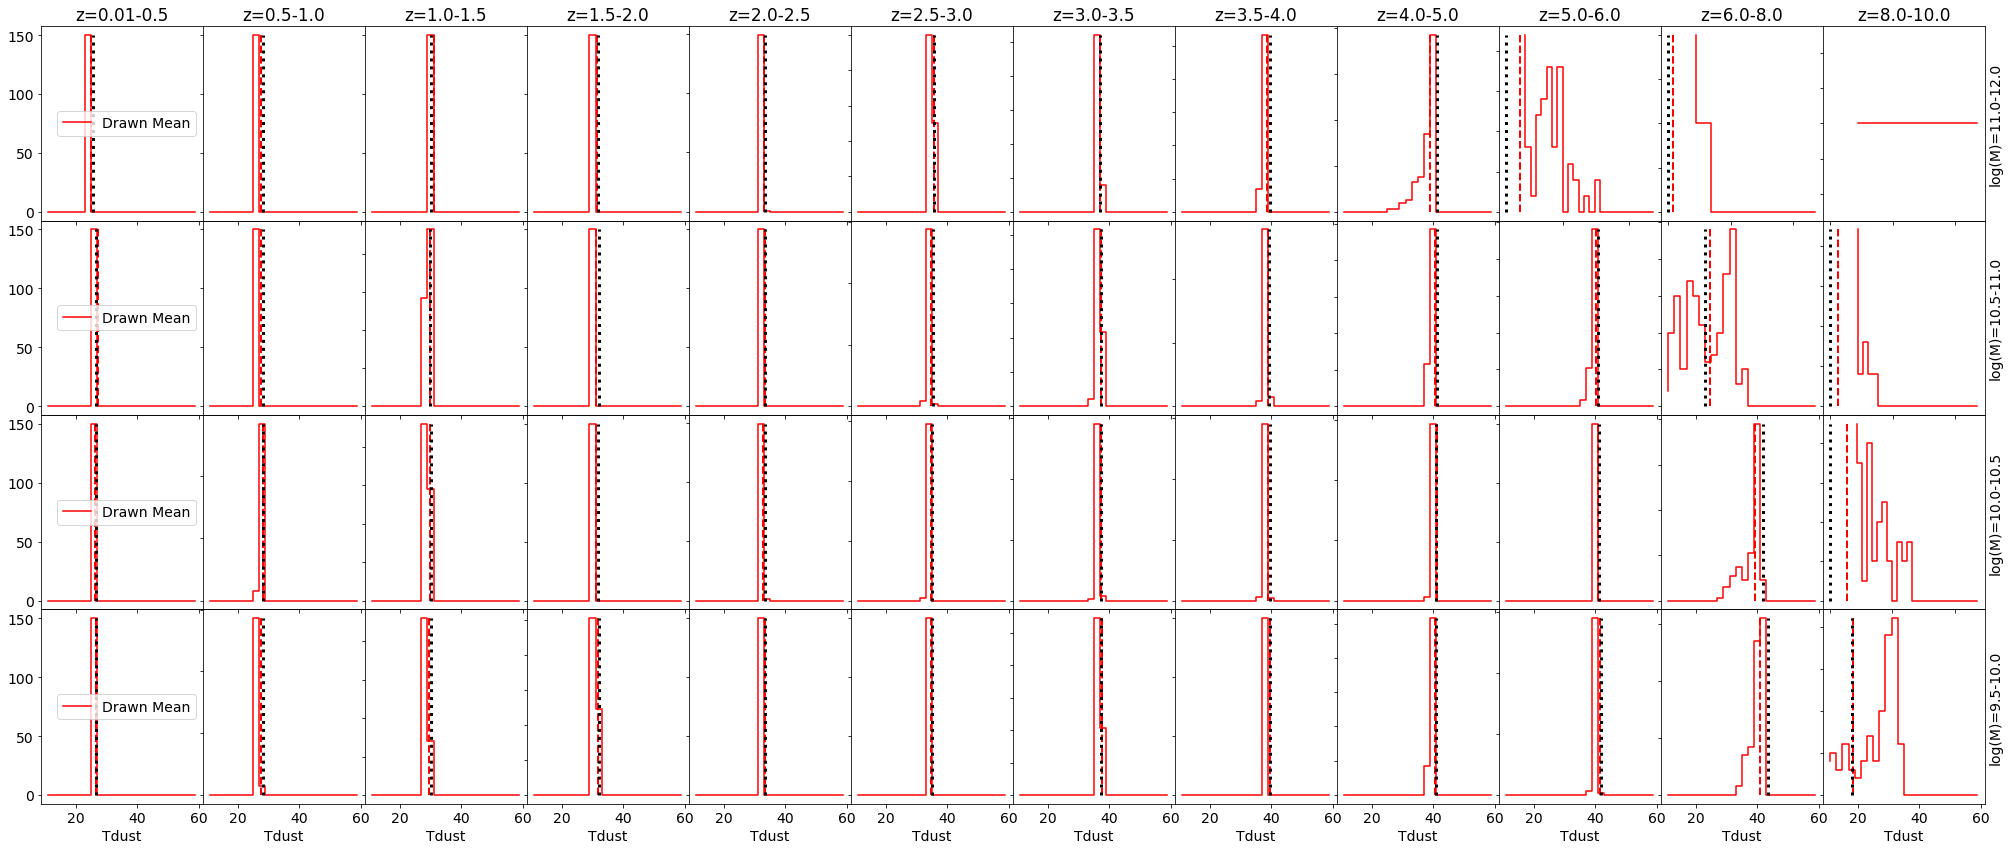

In [89]:
# Histogram of mean effective rest-frame Tdust of objects in each bin.  Black are at the nominal redshifts, and red are redshifts drawn from each objects P(z). 
# Where the simulation mean is strongly peaked the influence of outliers in minimal.  At z>6 
# The absence of signal in high-redshift, high-mass bins, and z>9, reflect the limits of the SIDES simulation.  
plot_tdust_hist_from_pz_mean_simulation(simstack_object, imported_sed_sim)

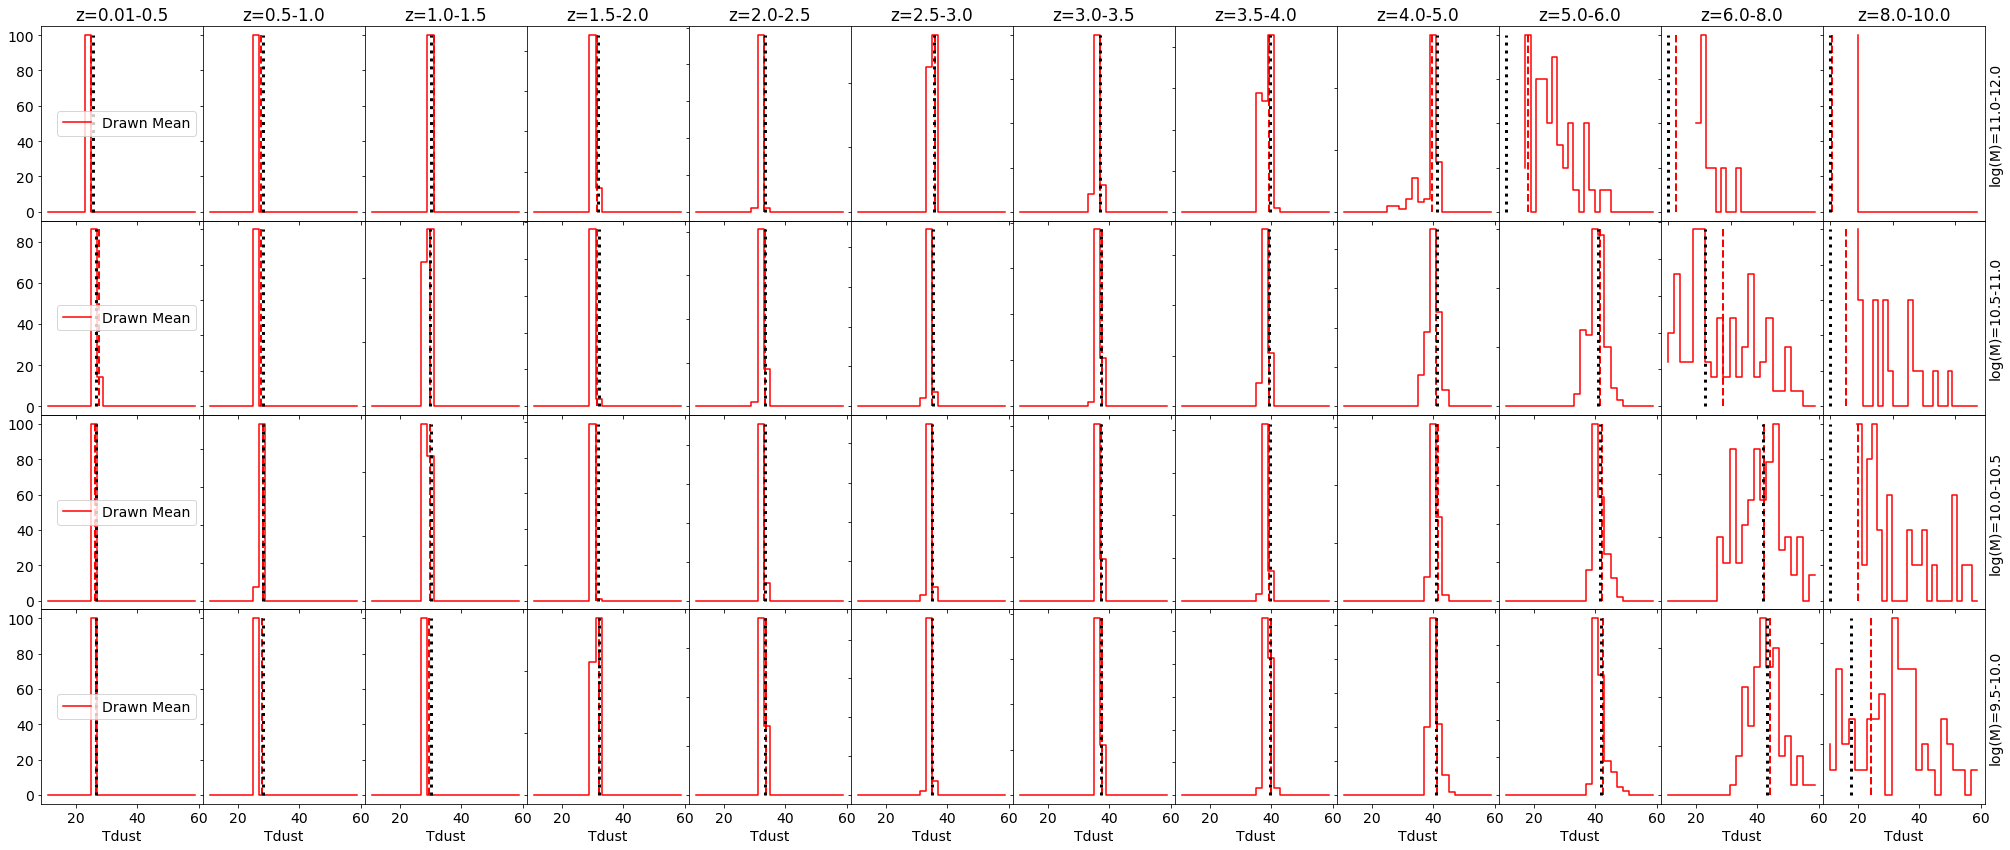

In [48]:
# Histogram of mean effective rest-frame Tdust of objects in each bin.  Black are at the nominal redshifts, and red are redshifts drawn from each objects P(z). 
# Where the simulation mean is strongly peaked the influence of outliers in minimal.  At z>6 
# The absence of signal in high-redshift, high-mass bins, and z>9, reflect the limits of the SIDES simulation.  
plot_tdust_hist_from_pz_mean_simulation(simstack_object, sed_sim_100)

## Average binned SEDs where redshifts drawn from P(Z)

As the redshift increases and stellar mass decreases, the P(z) broadens, and the contribution from objects outside the nominal bin edges increases.  

We find a small bias towards hotter dust temperature at z>6, but a large increase in uncertainty.  

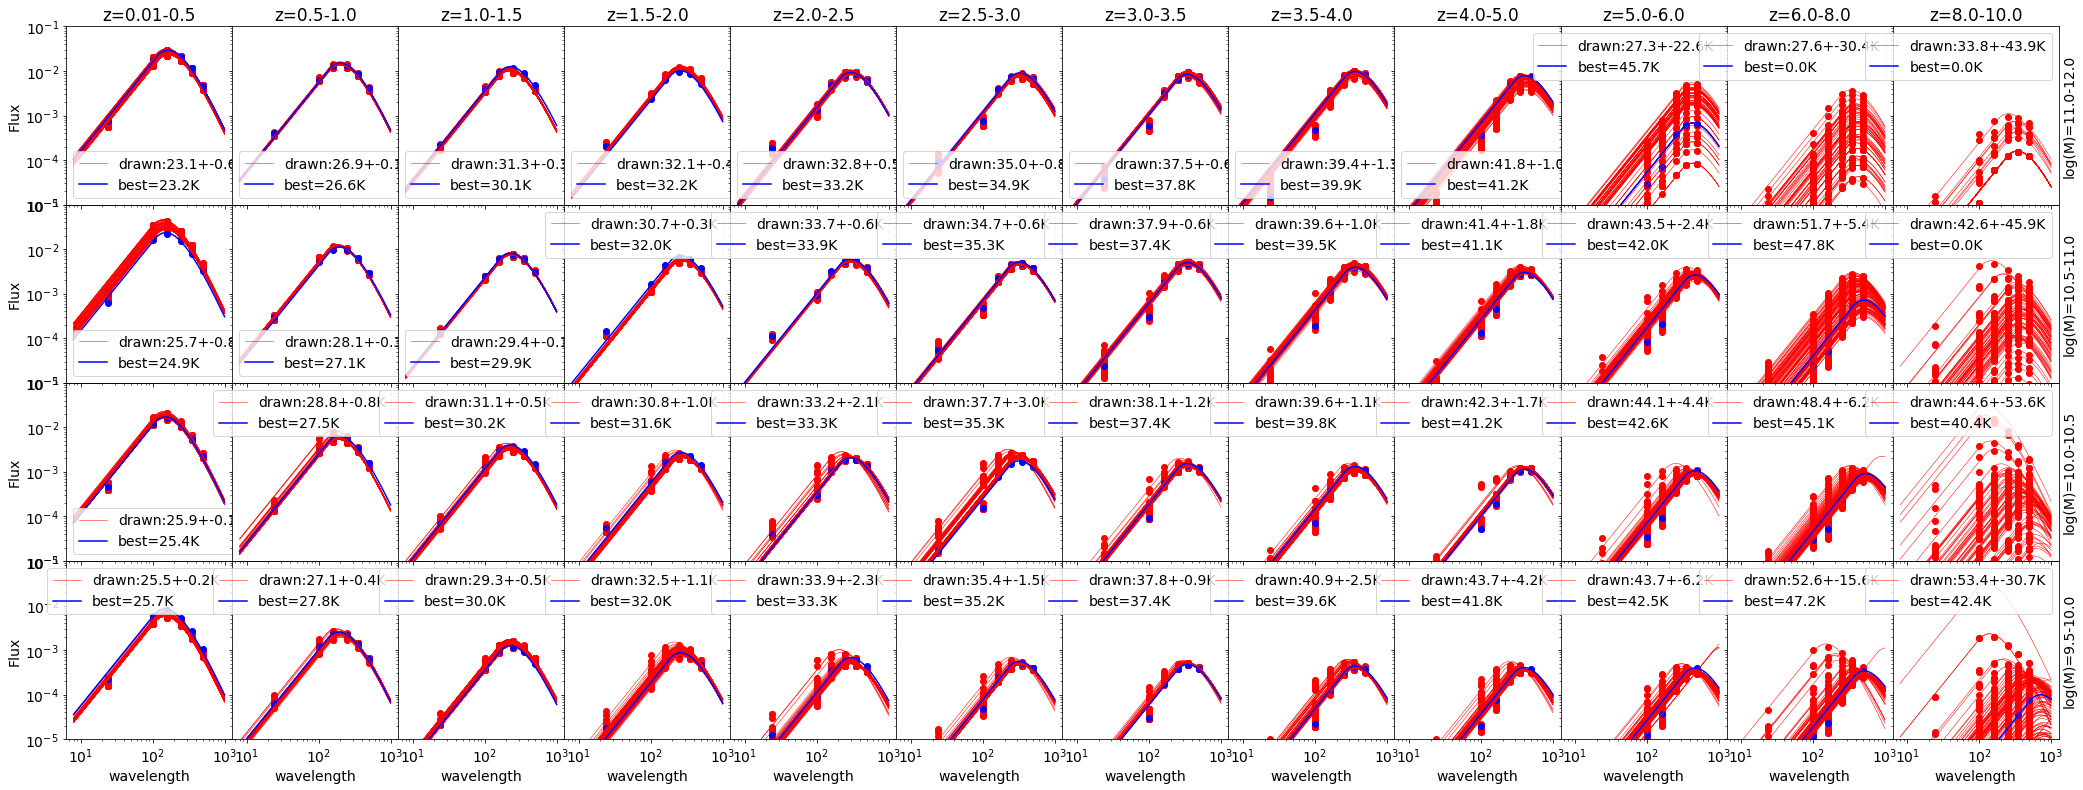

In [71]:
# SED fits to averaged fluxes in bins, where redshifts are drawn from P(z)
# Blue are nominal redshifts (i.e., lp_zBEST used in paper), and Red are sims drawn from P(z)
plot_mean_sed_from_pz_full_simulation(simstack_object, imported_sed_sim)

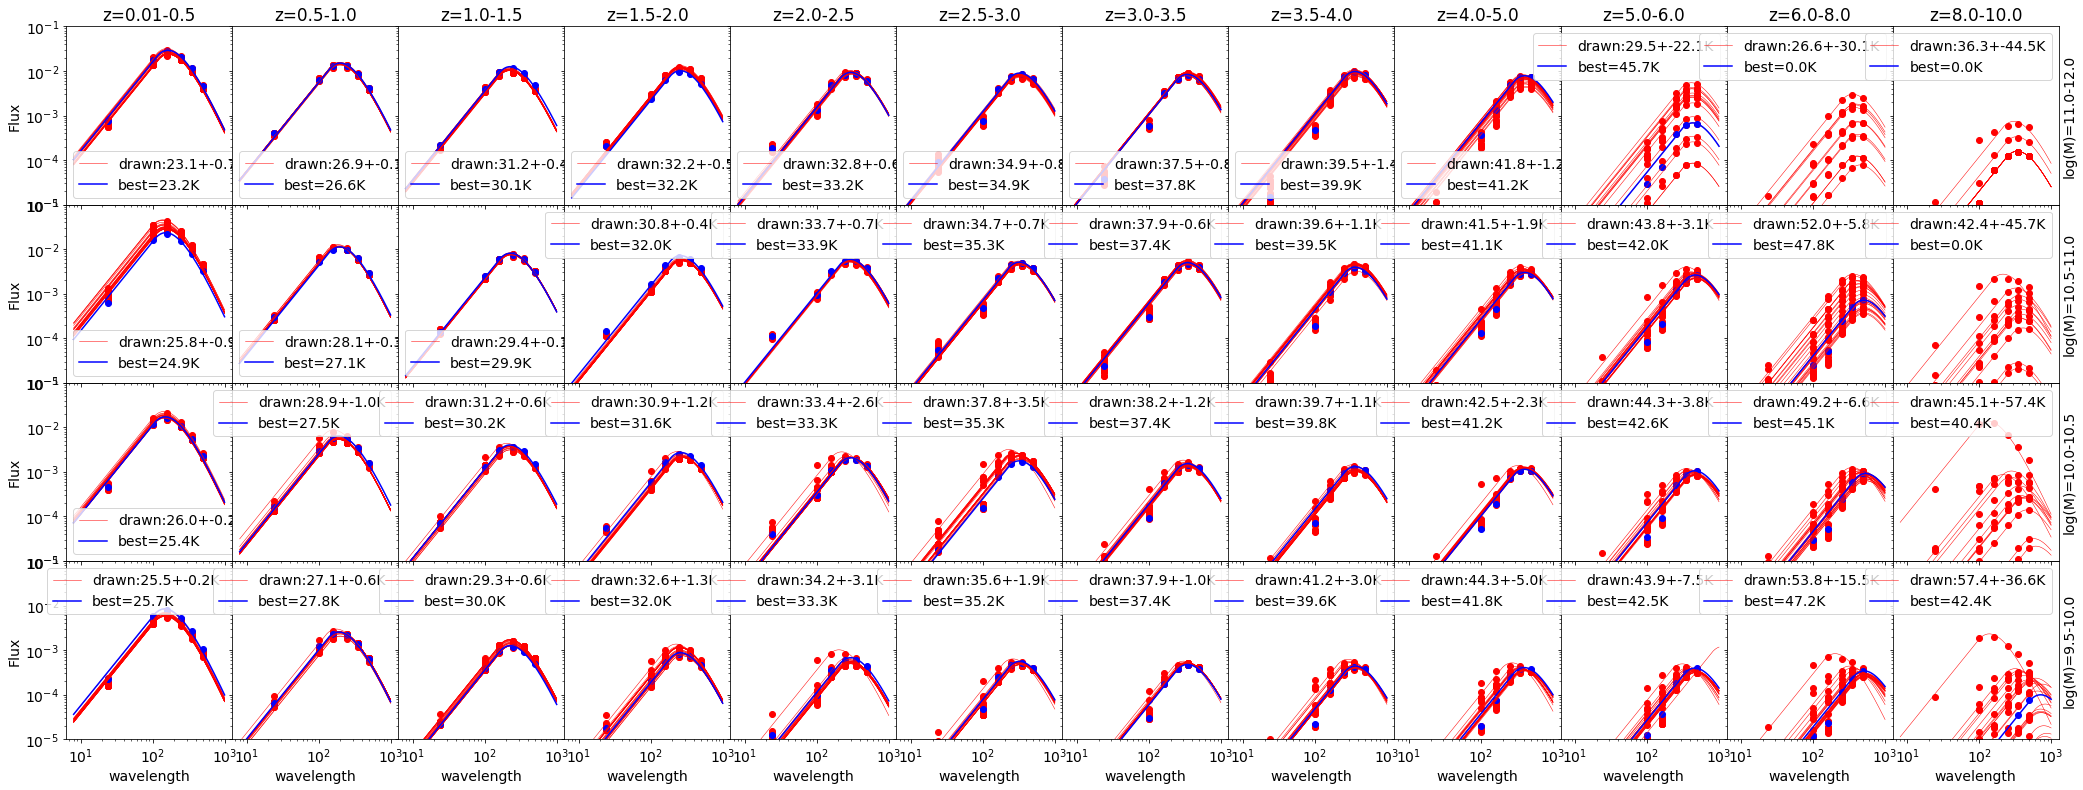

In [31]:
# SED fits to averaged fluxes in bins, where redshifts are drawn from P(z)
# Blue are nominal redshifts (i.e., lp_zBEST used in paper), and Red are sims drawn from P(z)
plot_mean_sed_from_pz_full_simulation(simstack_object, sed_sim_25)

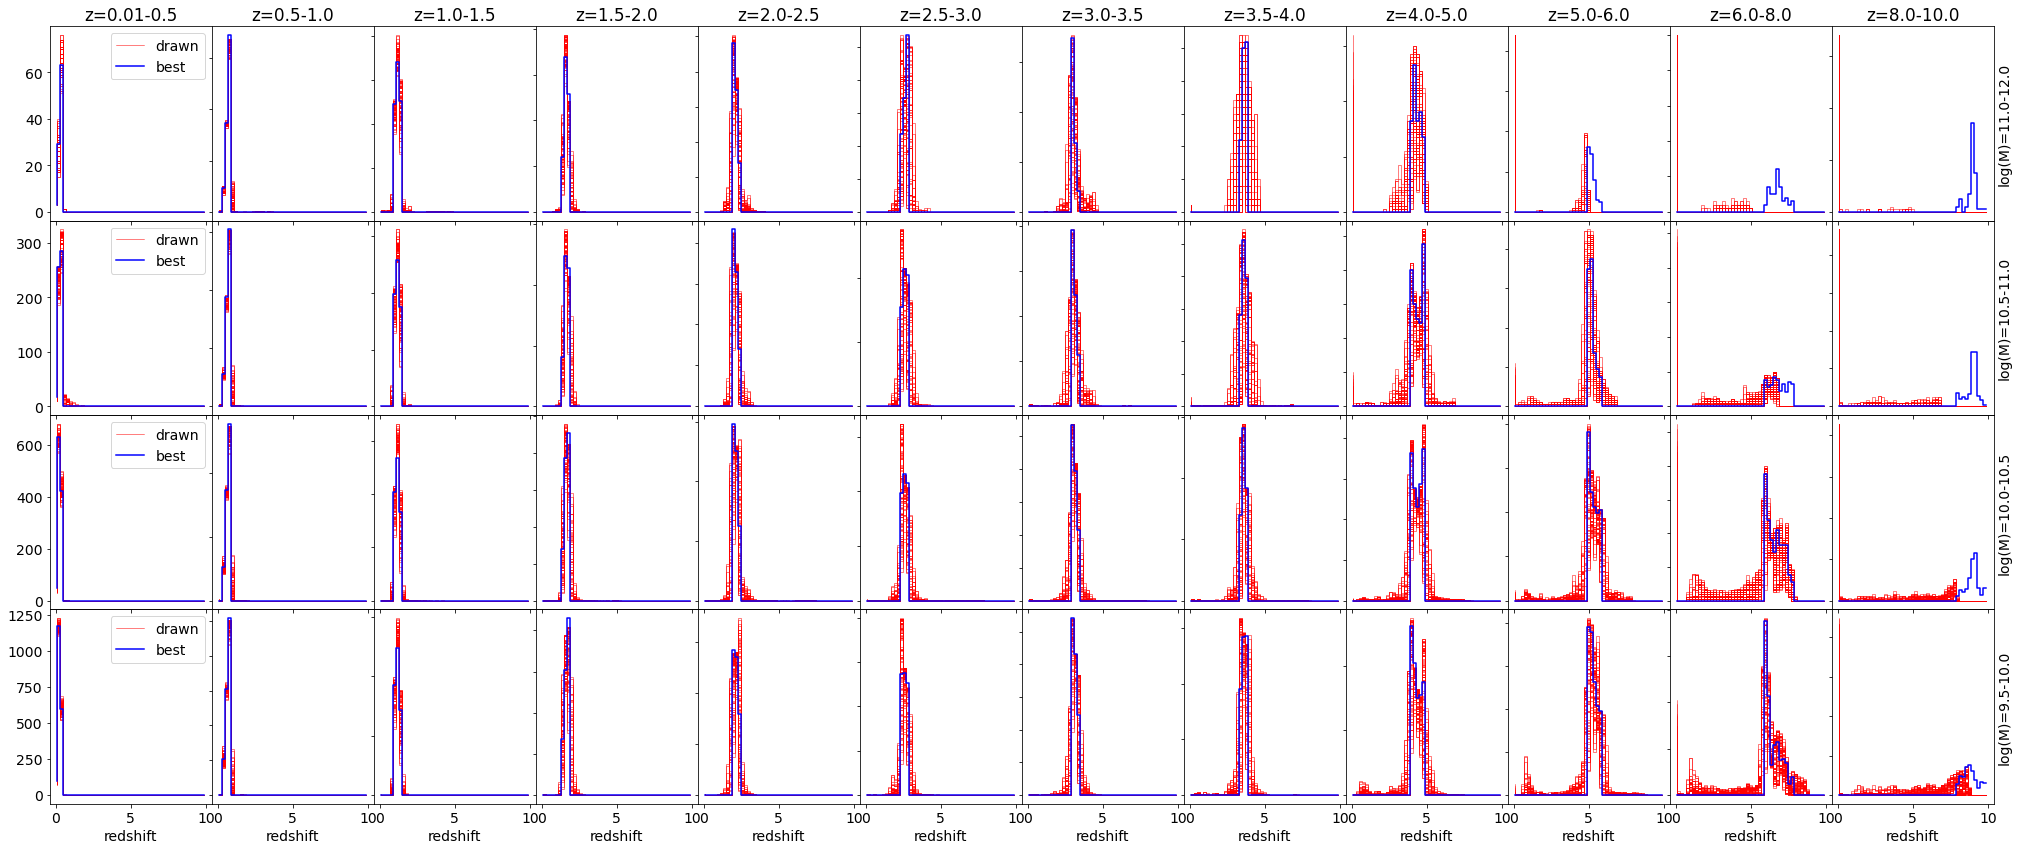

In [72]:
# Redshift distribution of objects in each bin.  Blue are the nominal redshifts, and red are redshifts drawn from each objects P(z).  Note the emergence of double peaks at z>4, which provides reassurance that the sim is working as intended.
# The absence of signal in high-redshift, high-mass bins, and z>9, reflect the limits of the SIDES simulation.  
plot_redshift_hist_from_pz_full_simulation(simstack_object, imported_sed_sim)

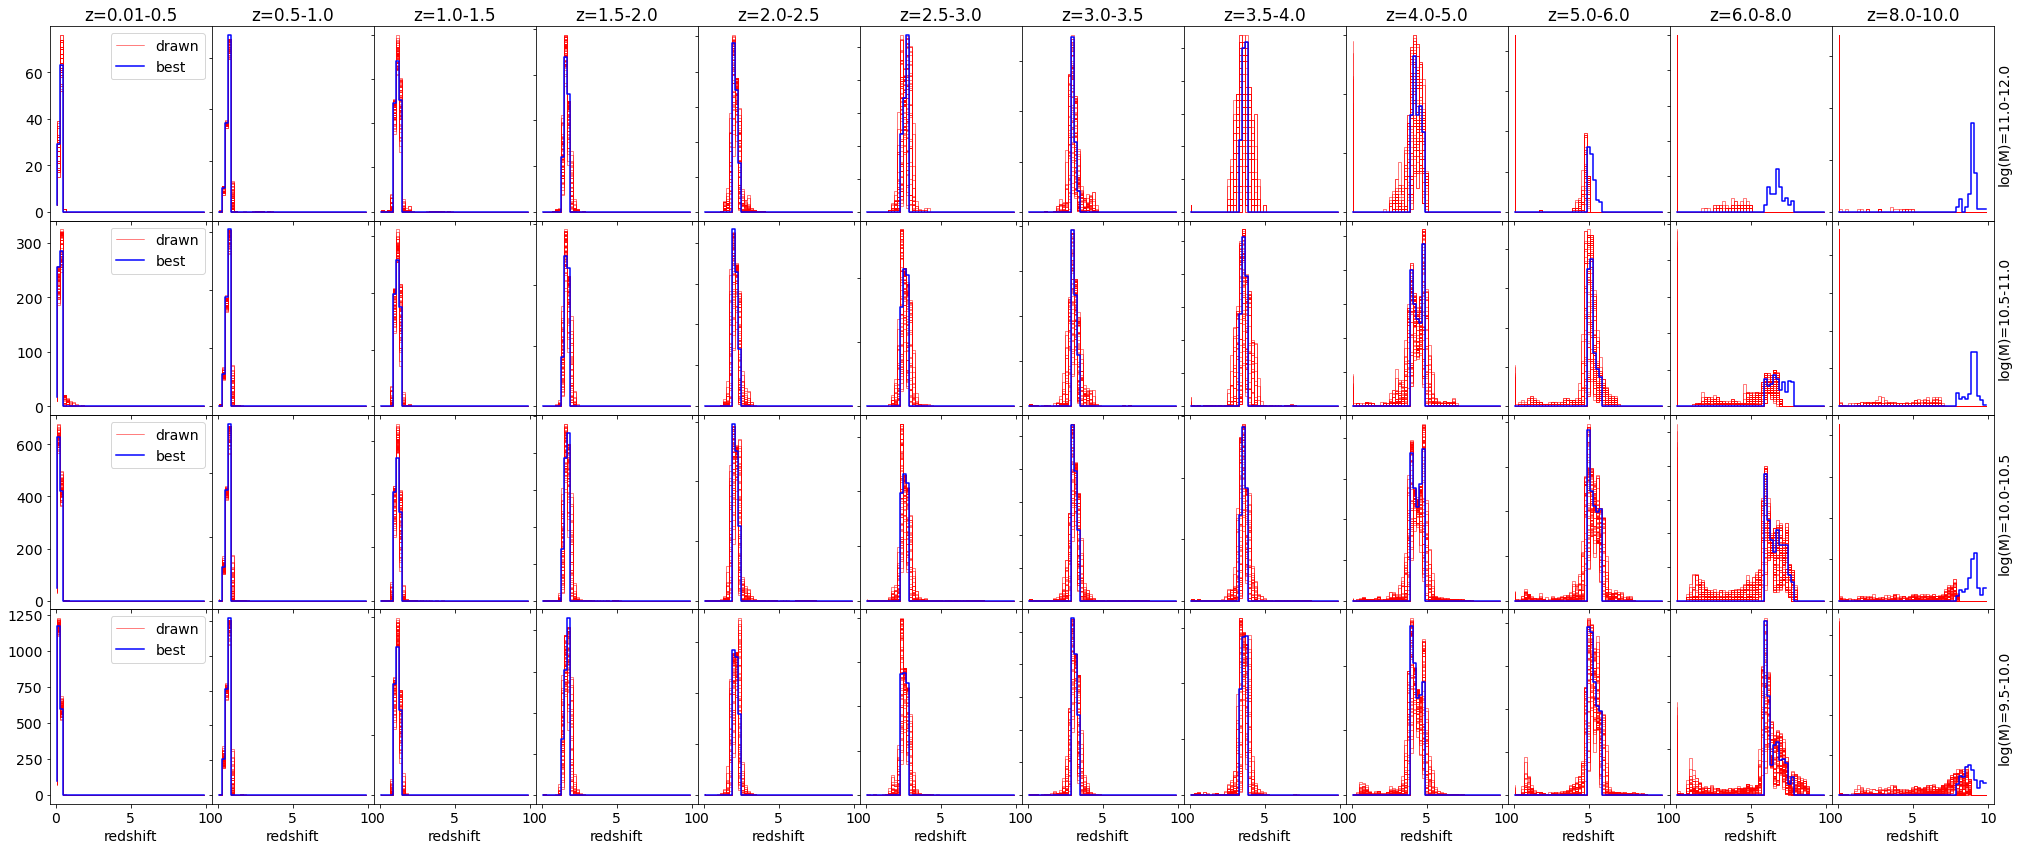

In [33]:
# Redshift distribution of objects in each bin.  Blue are the nominal redshifts, and red are redshifts drawn from each objects P(z).  Note the emergence of double peaks at z>4, which provides reassurance that the sim is working as intended.
# The absence of signal in high-redshift, high-mass bins, and z>9, reflect the limits of the SIDES simulation.  
plot_redshift_hist_from_pz_full_simulation(simstack_object, sed_sim_100)

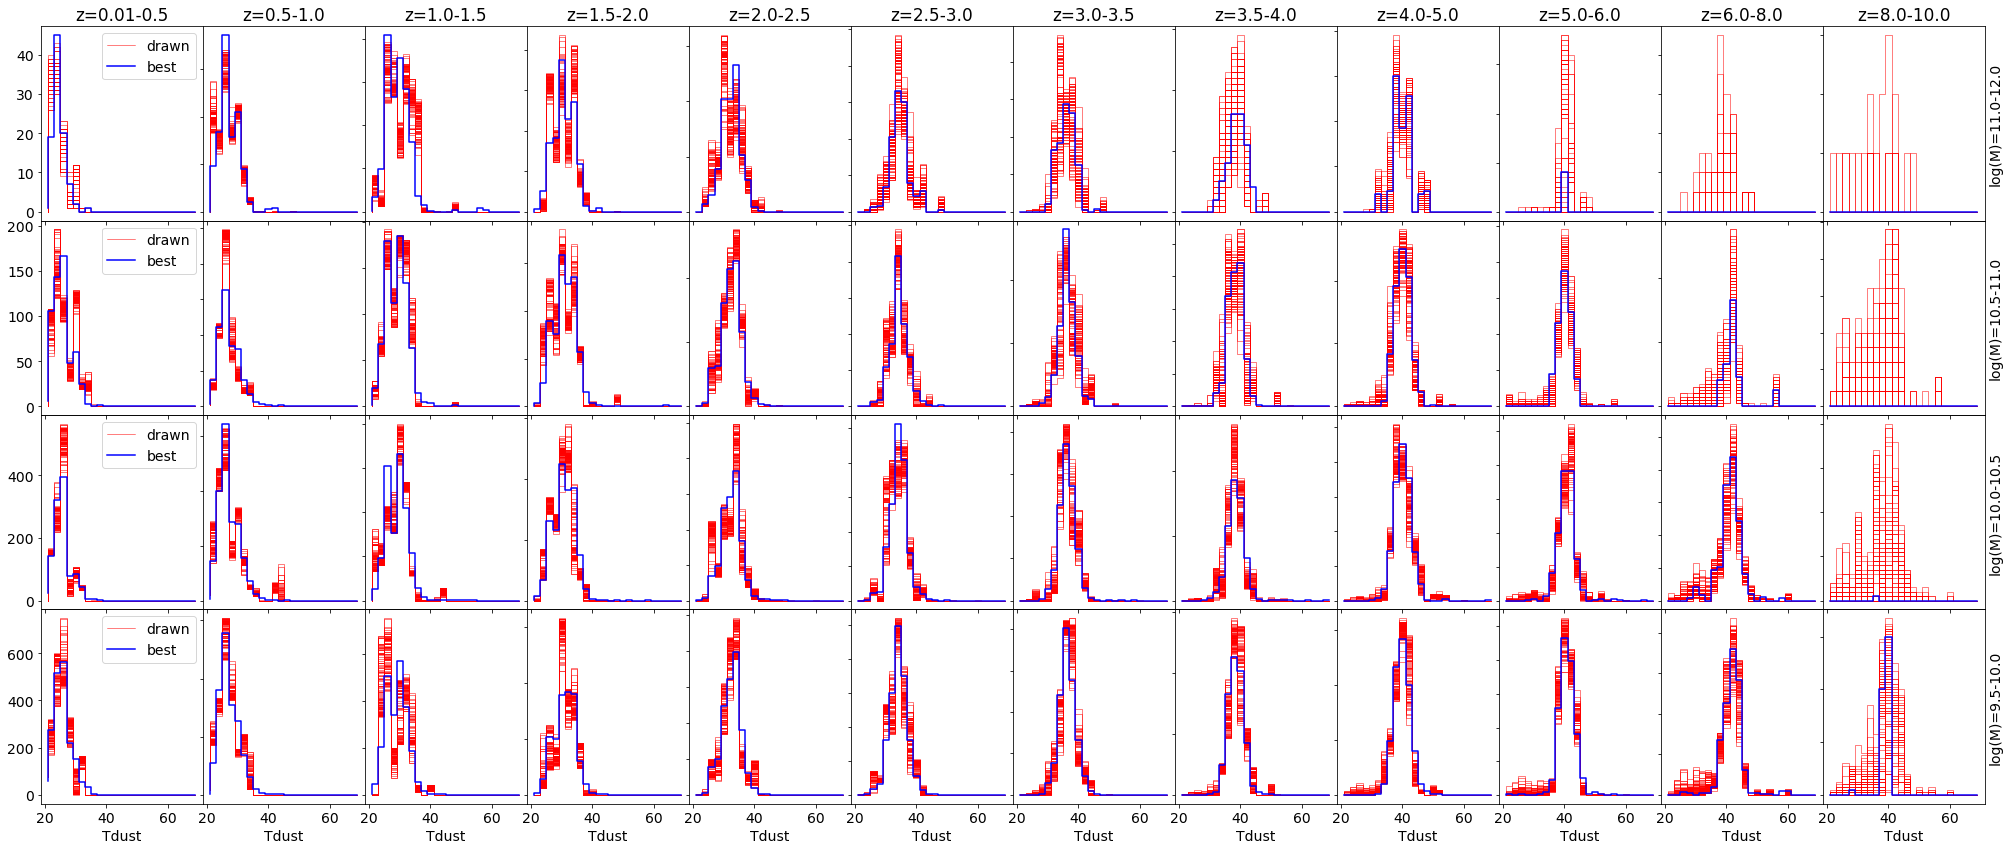

In [73]:
# Histogram of effective rest-frame Tdust of objects in each bin.  Blue are the nominal redshifts, and red are redshifts drawn from each objects P(z). 
# As anticipated there is an excess of hot sources at high redshift as they are confused lower redshift objects; we find that they bias the result, but the effect is subdominant to the increased variance.  
# The absence of signal in high-redshift, high-mass bins, and z>9, reflect the limits of the SIDES simulation.  
plot_tdust_hist_from_pz_full_simulation(simstack_object, imported_sed_sim)

In [34]:
def plot_dT_from_pz_full_simulation(self, sim_dict):
    
    bin_keys = list(sim_dict['bin_dict'].keys())
    wavelengths = sim_dict['wavelengths']
    #bin_keys = list(self.config_dict['parameter_names'].keys())    
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(mlen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(41, 11))
    
    fluxes_best = sim_dict['sbest']
    fluxes_drawn = sim_dict['sdrawn']
    tdust_best = sim_dict['tbest']
    tdust_drawn = sim_dict['tdrawn']
    redshifts_best = sim_dict['zbest']
    redshifts_drawn = sim_dict['zdrawn']
    ave_theta_best = sim_dict['theta_best']
    ave_theta_drawn = sim_dict['theta_drawn']
    ngals_bin = sim_dict['ngals']
        
    wv_mod = np.linspace(8,1000,1000)
    for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
        for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
            if ip:
                for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                    id_label = "__".join([zlab, mlab, plab])
                    ngals = ngals_bin[id_label]

                    m = [float(i) for i in mlab.split('_')[2:]]
                    z = [float(i) for i in zlab.split('_')[1:]]
                    
                    ax = plt.subplot(gs[3-im, iz])
                    ax.set_yscale('log')
                    ax.set_xlim([-2,5])
                    ax.set_ylim([2e0,3e2])
                    ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))

                    nsims = len(fluxes_drawn[id_label])
                    tdust_drawn_sim = np.zeros(nsims)
                    dT_all = ave_theta_drawn[id_label][:,1] - ave_theta_best[id_label][1]

                    hb = np.linspace(-4,12,34)
                    hy, hx = np.histogram(dT_all[abs(dT_all) > 0], bins=hb)
                    ax.step((hx[:-1]+hx[1:])/2, hy, c='r',lw=1.0) 
                    
                    if abs(np.mean(dT_all[abs(dT_all) > 0]) > 2.9):
                        dlabel = "N/A"
                    else:
                        dlabel = "dT={0:0.1f}K".format(np.mean(dT_all[abs(dT_all) > 0]))
                    ax.vlines(np.mean(dT_all[abs(dT_all) > 0]), min(hy), max(hy), color='k', ls=':', lw=3) 
                    ax.vlines(0, min(hy), max(hy), color='r', ls='--', lw=2, label=dlabel)
                    ax.legend(loc='upper right')

                    if im:
                        ax.set_xticklabels([])
                    else:
                        ax.set_xlabel('Delta T')

                    if iz:
                        ax.set_yticklabels([])
                    #else:
                    #    ax.set_ylabel('Histogram')

                    if iz == zlen - 1:
                        ax.yaxis.set_label_position("right")
                        ax.set_ylabel(mlab.replace('stellar_mass_', 'log(M)=').replace('_', '-'))

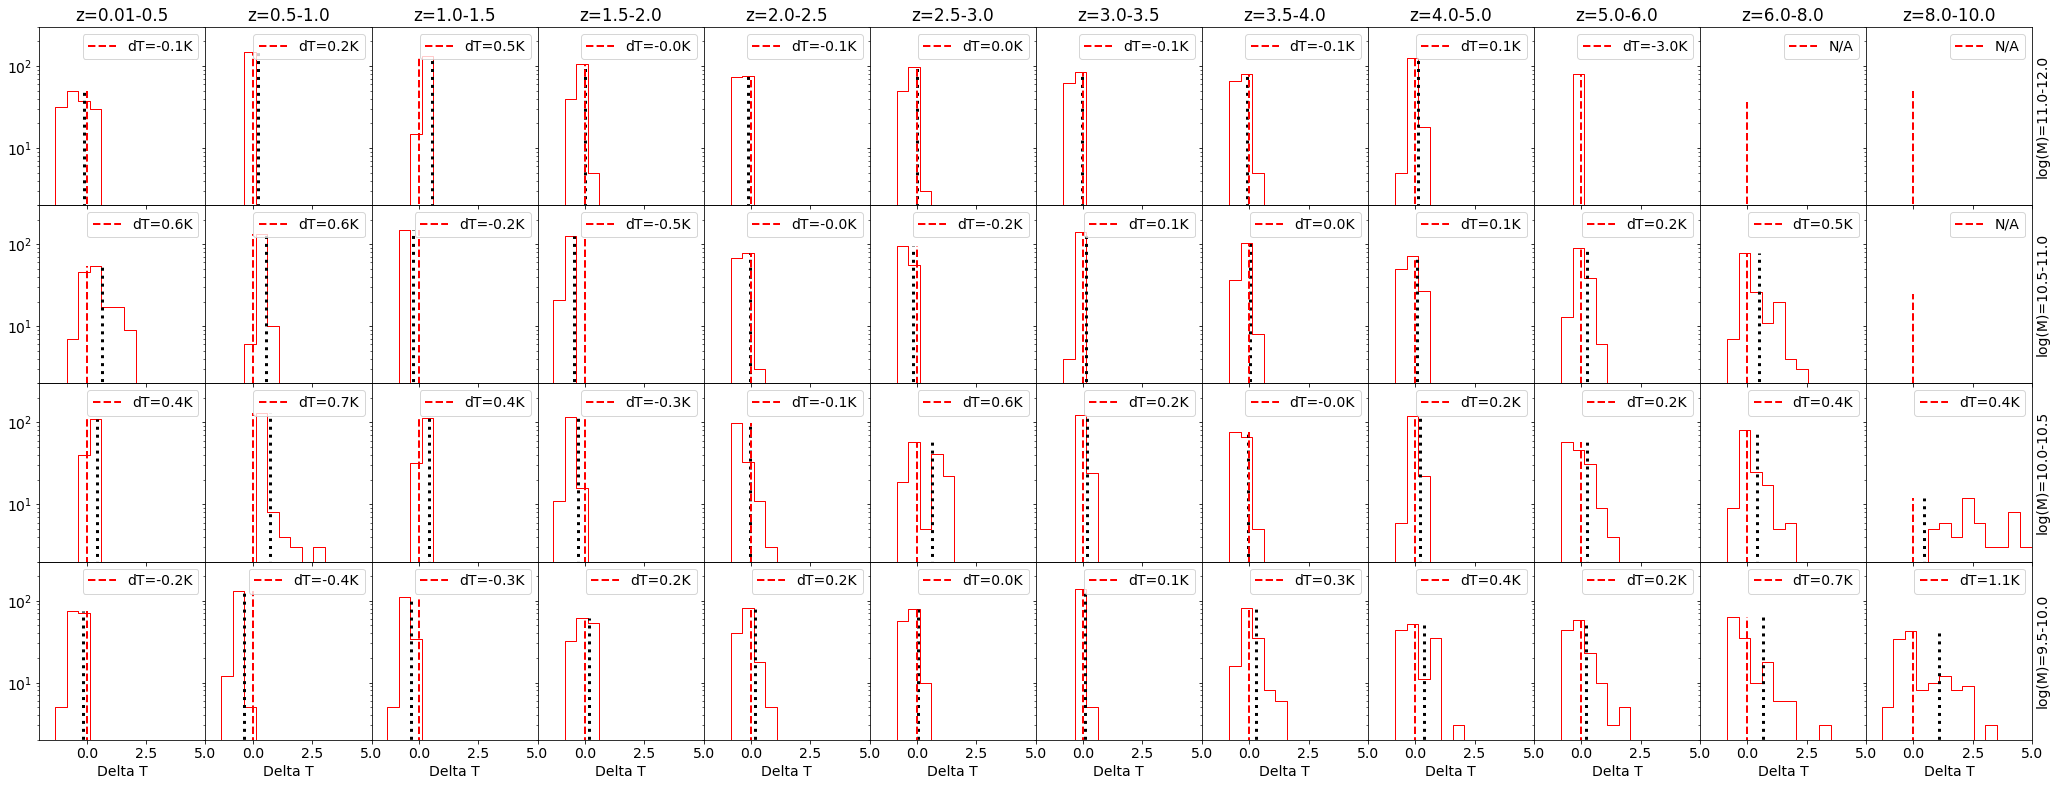

In [87]:
plot_dT_from_pz_full_simulation(simstack_object, imported_sed_sim)

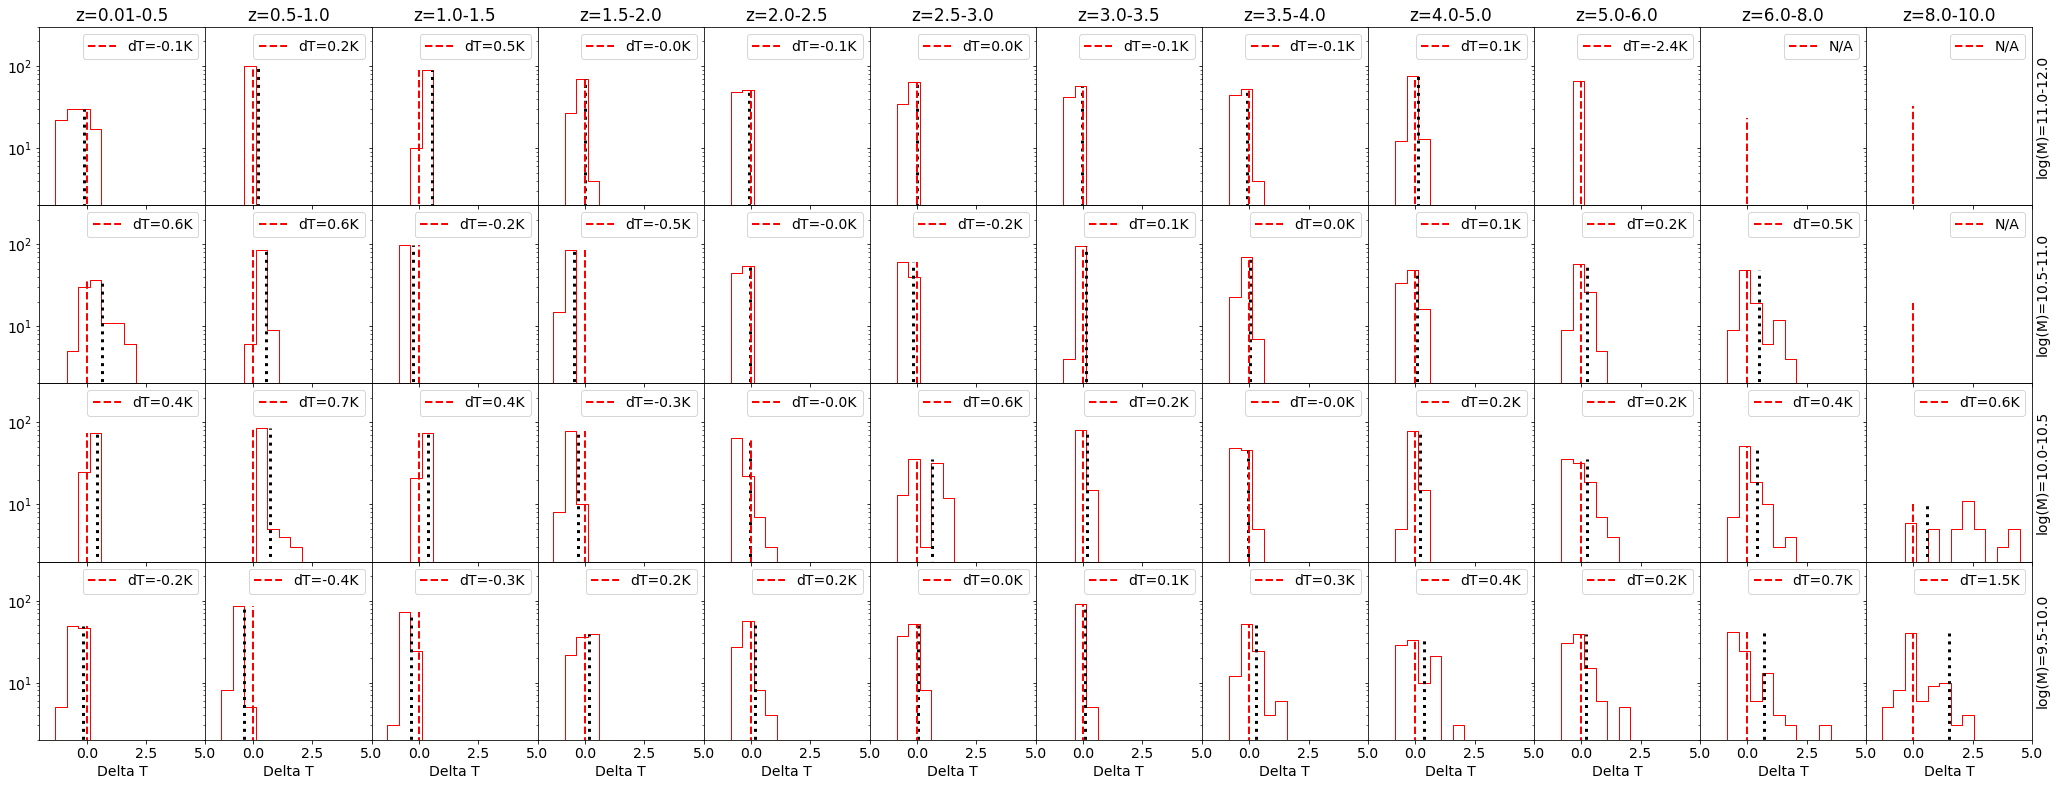

In [35]:
plot_dT_from_pz_full_simulation(simstack_object, sed_sim_100)